## This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on faces data set (real/fake faces). 

## Imports and Parameters

In [320]:
import time
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2

This cell defines paramaters of the algorithm: 
- `eps0`: initial learning rate that is linearly annealed during training
- `N_hid`: number of hidden units that are displayed as an `Ky` by `Kx` array by the `draw_weights` function defined below
- `mu`: the mean of the gaussian distribution that initializes the weights
- `sigma`: the standard deviation of that gaussian 
- `Nep`: number of epochs
- `N_batch`: size of the minibatch
- `prec`: parameter that controls numerical precision of the weight updates
- `delta`: the strength of the anti-hebbian learning
- `p`: Lebesgue norm of the weights; `k` - ranking parameter. 
- `N_in`: number of input units
- `val_split`: the proportion of validation split

In [562]:
eps0 = 4e-2    # initial learning rate for the unsupervised part
Kx = 5
Ky = 5
hid_disp = Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
N_hid = 1000    # number of hidden units
mu = 0.0
sigma = 1.0
Nep = 2000     # number of epochs
N_batch = 100  # size of the minibatch
prec = 1e-30
delta = 0.4    # Strength of the anti-hebbian learning
p = 3        # Lebesgue norm of the weights
k = 3          # ranking parameter, must be integer that is bigger or equal than 2

N_in = 3072     # input units
Nc = 2        # number of classes
val_split = 0.25

In [393]:
# a utility function to shuffle training and testing samples
def shuffle(xt, yt, xv, yv):
    
    # xt, yt: training samples and labels
    # xv, yv: validation samples and labels
    
    pt = np.random.permutation(len(xt))
    pv = np.random.permutation(len(xv))
    return(xt[pt], yt[pt], xv[pv], yv[pv])

## Data
Let's load the data from [here](https://drive.google.com/file/d/1fGJw_WIZgFwfs5KZtcc_1sCRJGaYxvCb/view?usp=sharing):
- Load the 1081 real and 960 fake samples, unzip the folder
- Rename the directories for the real and fake images
- Reshape images to (#samples, 3x32x32) or (#samples, 32x32) and labels to (#samples, 2)
- Split the train part to 1474 and 260 validation samples

In [395]:
#renaming real and fake directories
real = "../CompVP project/real_and_fake_face/training_real/"
fake = "../CompVP project/real_and_fake_face/training_fake/"
#we're creating a list of real and fake images
real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [396]:
print(len(real_path))
print(len(fake_path))

1081
960


### 2-channel images

In [443]:
def create_arr_data_2ch(_dir, _path, _class, img_size):
    X = []
    y=[]
    for img in tqdm(_path):
        path = os.path.join(_dir, img)
        image = cv2.resize(cv2.imread(path), (img_size,img_size))
        img = Image.fromarray(np.array(image))
        imgage_convert = img.convert('L')  #convert a gray scale
        X.append(np.array(imgage_convert))
        y.append(_class)
    return X, y

In [472]:
X_real_data, y_real_data = create_arr_data_2ch(real, real_path, 1, 32)
X_fake_data, y_fake_data = create_arr_data_2ch(fake, fake_path, 0, 32)

100%|████████████████████████████████████████████████████████████████████████████████| 960/960 [00:30<00:00, 31.28it/s]


In [538]:
x = np.concatenate((X_real_data, X_fake_data), axis=0)
y = np.concatenate((y_real_data, y_fake_data), axis=0)

x_train_2ch, x_test_2ch, y_train_2ch, y_test_2ch = train_test_split(x, y, test_size=val_split, random_state=42)

In [539]:
# reshape to (# samples, 1024)
x_train_2ch = x_train_2ch.reshape(x_train_2ch.shape[0], x_train_2ch.shape[1] * x_train_2ch.shape[2])
x_test_2ch = x_test_2ch.reshape(x_test_2ch.shape[0], x_test_2ch.shape[1] * x_test_2ch.shape[2])

x_train_2ch = x_train_2ch.astype('float32') / 255.0
x_test_2ch = x_test_2ch.astype('float32') / 255.0

# shuffle
x_train_2ch, y_train_2ch, x_test_2ch, y_test_2ch = shuffle(x_train_2ch, y_train_2ch, x_test_2ch, y_test_2ch)

# indices of validation splilt
val_idx = np.random.choice(x_train_2ch.shape[0], int(val_split * x_train_2ch.shape[0]), replace=False)

#split validation
x_val_2ch = x_train_2ch[val_idx]
y_val_2ch = y_train_2ch[val_idx]
x_train_2ch = np.delete(x_train_2ch, val_idx, axis=0)
y_train_2ch = np.delete(y_train_2ch, val_idx, axis=0)
y_test_2ch_one = y_test_2ch
y_val_2ch_one = y_val_2ch
y_train_2ch_one = y_train_2ch

# some logging
print("x_train shape:", x_train_2ch.shape)
print("y_train shape:", y_train_2ch.shape)
print("x_val shape:", x_val_2ch.shape)
print("y_val shape:", y_val_2ch.shape)
print(x_train_2ch.shape[0], "train samples")
print(x_test_2ch.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train_2ch = keras.utils.to_categorical(y_train_2ch, Nc)
y_val_2ch = keras.utils.to_categorical(y_val_2ch, Nc)
y_test_2ch = keras.utils.to_categorical(y_test_2ch, Nc)

x_train shape: (1148, 1024)
y_train shape: (1148,)
x_val shape: (382, 1024)
y_val shape: (382,)
1148 train samples
511 test samples


In [540]:
N_train_2ch = x_train_2ch.shape[0]
N_val_2ch = x_val_2ch.shape[0]
N_test_2ch = x_test_2ch.shape[0]
N_in_2ch = 1024

### 3-channel images

In [541]:
def create_arr_data(_dir, _path, _class, img_size):
    X = []
    y=[]
    for img in tqdm(_path):
        path = os.path.join(_dir, img)
        image = cv2.resize(cv2.imread(path), (img_size,img_size))
        X.append(np.array(image))
        y.append(_class)
    return X, y

In [546]:
X_real_data, y_real_data = create_arr_data(real, real_path, 1, 32)
X_fake_data, y_fake_data = create_arr_data(fake, fake_path, 0, 32)

100%|████████████████████████████████████████████████████████████████████████████████| 960/960 [00:42<00:00, 22.84it/s]


In [547]:
x = np.concatenate((X_real_data, X_fake_data), axis=0)
y = np.concatenate((y_real_data, y_fake_data), axis=0)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=val_split, random_state=42)
print(x_train.shape)

(1530, 32, 32, 3)


In [548]:
# reshape to (# samples, 49152)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train -= x_train.mean(axis=0, keepdims=True) 
x_test -= x_test.mean(axis=0, keepdims=True)
x_train /= np.linalg.norm(x_train, ord=2, axis=1, keepdims=True)
x_test /= np.linalg.norm(x_test, ord=2, axis=1, keepdims=True)

# shuffle
x_train, y_train, x_test, y_test = shuffle(x_train, y_train, x_test, y_test)

# indices of validation splilt
val_idx = np.random.choice(x_train.shape[0], int(val_split * x_train.shape[0]), replace=False)

#split validation
x_val = x_train[val_idx]
y_val = y_train[val_idx]
x_train = np.delete(x_train, val_idx, axis=0)
y_train = np.delete(y_train, val_idx, axis=0)
y_train_one = y_train
y_val_one = y_val
y_test_one = y_test

# some logging
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, Nc)
y_val = keras.utils.to_categorical(y_val, Nc)
y_test = keras.utils.to_categorical(y_test, Nc)

x_train shape: (1148, 3072)
y_train shape: (1148,)
x_val shape: (382, 3072)
y_val shape: (382,)
1148 train samples
511 test samples


In [549]:
N_train = x_train.shape[0]
N_val = x_val.shape[0]
N_test = x_test.shape[0]

## Weights visualization
To draw a heatmap of the weights a helper function is created:

In [590]:
def draw_weights(synapses, Kx, Ky, num_file=-1, ax=None):
    # synapses: the weights
    Kw = int(np.sqrt(synapses.shape[1]//3)) # i.e. 32
    yy=0
    HM=np.zeros((Kw*Ky, Kw*Kx, 3))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*Kw:(y+1)*Kw,x*Kw:(x+1)*Kw]=synapses[yy,:Kw*Kw*3].reshape(Kw, Kw, 3)
            yy += 1
   
    nc=np.amax(np.absolute(HM))
    tmp = (HM-HM.min())
    tmp /= tmp.max() 
    tmp *= 255
    tmp = tmp.astype(np.uint8)
    if ax is not None:
        im = ax.imshow(tmp)
        ax.axis('off')
    else:
        plt.clf()
        im=plt.imshow(tmp.astype(np.uint8))
        plt.axis('off')
    
    if num_file > -1:
        file_name = '../CompVP project/fake-real-faces-3ch-color/' + str(num_file) + '.png'
        plt.savefig(file_name)
    fig.canvas.draw() 

In [591]:
def draw_weights_2ch(synapses, Kx, Ky, num_file=-1, ax=None):
    # synapses: the weights
    yy=0
    HM=np.zeros((32*Ky,32*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*32:(y+1)*32,x*32:(x+1)*32] = synapses[yy, :].reshape(32,32)
            yy += 1
   
    nc=np.amax(np.absolute(HM))
    
    if ax is not None:
        im = ax.imshow(HM, cmap='bwr', vmin=-nc, vmax = nc)
        fig.colorbar(im, ticks=[np.amin(HM), 0, np.amax(HM)], ax=ax)
        ax.axis('off')
    else:
        plt.clf()
        im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
        fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
        plt.axis('off')
    
    if num_file > -1:
        file_name = '../CompVP project/fake-real-faces-2ch-color/' + str(num_file) + '.png'
        plt.savefig(file_name)
    fig.canvas.draw() 

## Forward pass of the unsupervised part
This is one step of the training and returns the changes that should be applied to the weights in one iteration. 

**Note:** In the testing phase, we don't need to compute `h` or `g` functions, so we just return the input currents.
- Given the inputs and the synapses (weights), compute the input currents `tot_input` = <W.v>
    - This is referred to `I` in the paper.
- If we're in the testing phase, return `tot_input`
- If we're in the training phase, go on to use the rankings in the input currents as proxies for the final `h` and return the changes that should be application 

In [346]:
def forward(inputs, synapses, p, N_hid, N_batch, N_in, training=True):
    inputs = np.transpose(inputs)
    sig=np.sign(synapses)
    tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs) # with p=2, this is equal to <W.v> = I 
    

    if training == False:
        return tot_input.T
    
    # TODO: compute h...
    
    y=np.argsort(tot_input,axis=0) # using tot_input (I) as proxy for h
    yl=np.zeros((N_hid, N_batch)) # y1 = g(Q)
    yl[y[N_hid-1],np.arange(N_batch)]=1.0 # g(max_activation in I) = 1
    yl[y[N_hid-k],np.arange(N_batch)]=-delta # g(second max activation) = -0.4
#     if training == False:
#         return yl.T
    xx=np.sum(np.multiply(yl,tot_input),1) # g(Q) x <W, v>
    ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N_in)),synapses)
    # g(Q) (v_i - <W,v> W_i)
    nc=np.amax(np.absolute(ds))
    return ds, nc

## The unsupervised training of the hidden layer

### 2-channel images

<IPython.core.display.Javascript object>


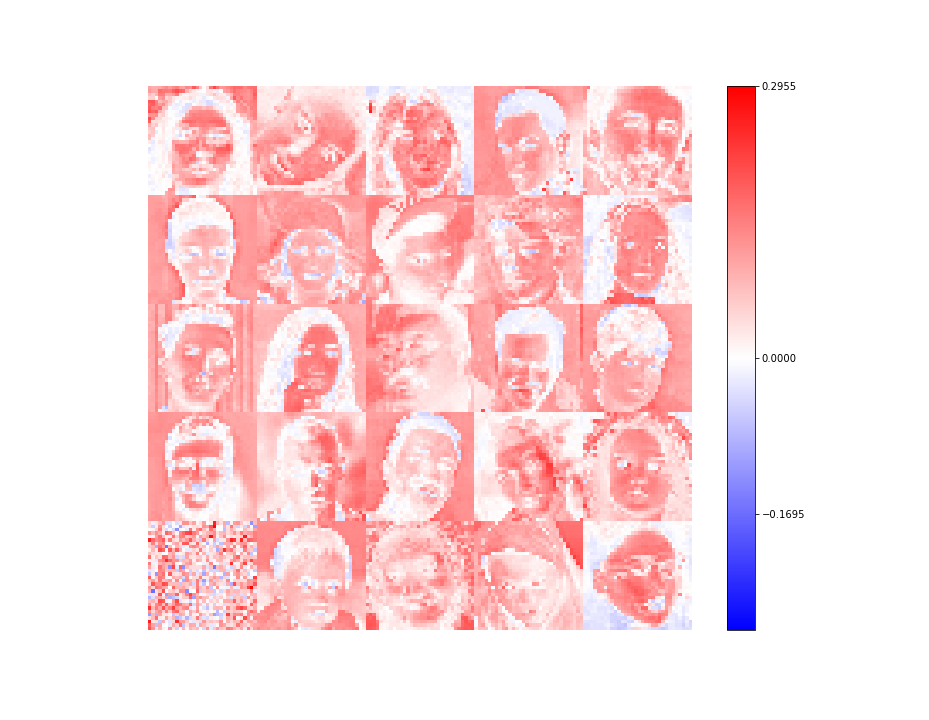

(1000, 1024)


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [49:48<00:00,  1.49s/it]


In [593]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))

file_num = 0
synapses_2ch = np.random.normal(mu, sigma, (N_hid, N_in_2ch)) # W
print(synapses_2ch.shape)
for nep in tqdm(range(Nep)):
    eps=eps0*(1-nep/Nep)
    for i in range(N_train_2ch//N_batch):
        inputs=x_train_2ch[i*N_batch:(i+1)*N_batch,:] # v_i 
        ds, nc = forward(inputs, synapses_2ch, p, N_hid, N_batch, N_in_2ch)
        if nc<prec:
            nc=prec
        synapses_2ch += eps*np.true_divide(ds,nc)
        
    draw_weights_2ch(synapses_2ch, Kx, Ky, file_num)
    file_num += 1

### 3-channel images

<IPython.core.display.Javascript object>


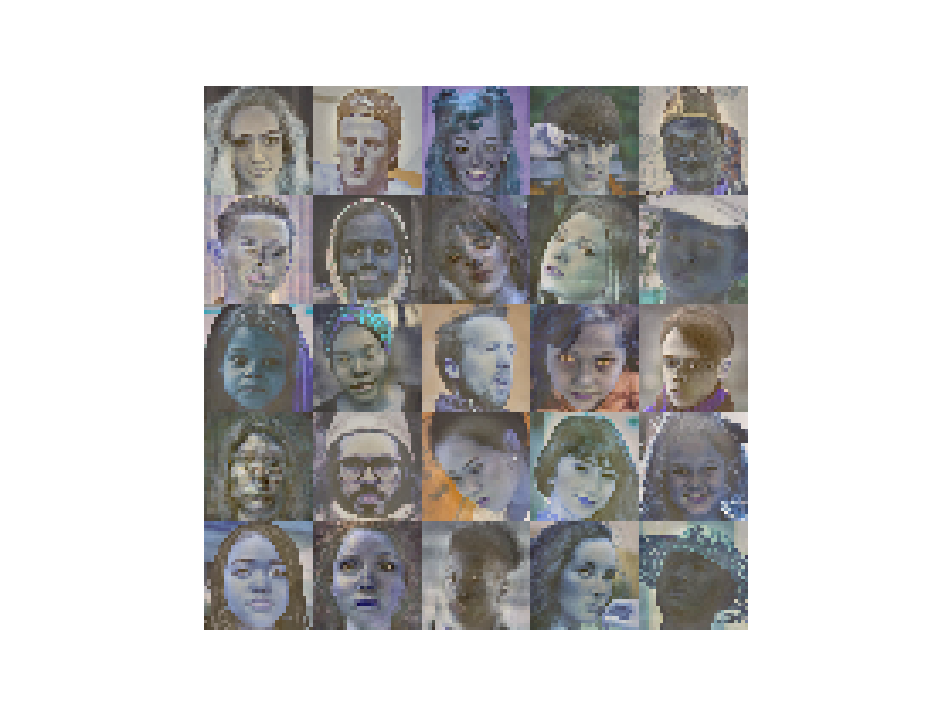

(1000, 3072)


100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:41:00<00:00,  3.03s/it]


In [596]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))

num_file = 0
synapses = np.random.normal(mu, sigma, (N_hid, N_in)) # W
print(synapses.shape)
for nep in tqdm(range(Nep)):
    eps=eps0*(1-nep/Nep)
    for i in range(N_train//N_batch):
        inputs=x_train[i*N_batch:(i+1)*N_batch,:] # v_i 
        ds, nc = forward(inputs, synapses, p, N_hid, N_batch, N_in)
        if nc<prec:
            nc=prec
        synapses += eps*np.true_divide(ds,nc)
        
    draw_weights(synapses, Kx, Ky, num_file)
    num_file += 1

## Saving or loading synapses
- If you want to save your own synapses from previous cell, uncomment and edit the first line
- If you want to load a pre-trained model, use the `np.load` function in the second line

A sample `synapses.npy` file for 3-channel images can be found [here](https://drive.google.com/file/d/1kc3FD6_Pm6OubBVaU1G9q_r9DwZbhL0k/view?usp=sharing)

A sample `synapses.npy` file for 2-channel images can be found [here](https://drive.google.com/file/d/18Iu72zHp9zSEd2pn_RhXKWVAR2DcDd1a/view?usp=sharing)


In [597]:
# save your own model
#np.save('FaceFakeDetection_new2_synapses_hid2000_epoch2000_eps2e-2_p2_k2_batch100_delta_0.4.npy', synapses_2ch)
#np.save('FaceFakeDetection_new2_2ch_synapses_hid2000_epoch2000_eps2e-2_p2_k2_batch100_delta_0.4.npy', synapses)

In [407]:
# load a pre-trained model
synapses = np.load('FaceFakeDetection_synapses_hid1000_epoch2000_eps2e-2_p3_k3_batch100_delta_0.4.npy')
synapses_2ch = np.load('FaceFakeDetection_2ch_synapses_hid1000_epoch2000_eps2e-2_p3_k3_batch100_delta_0.4.npy')

<IPython.core.display.Javascript object>


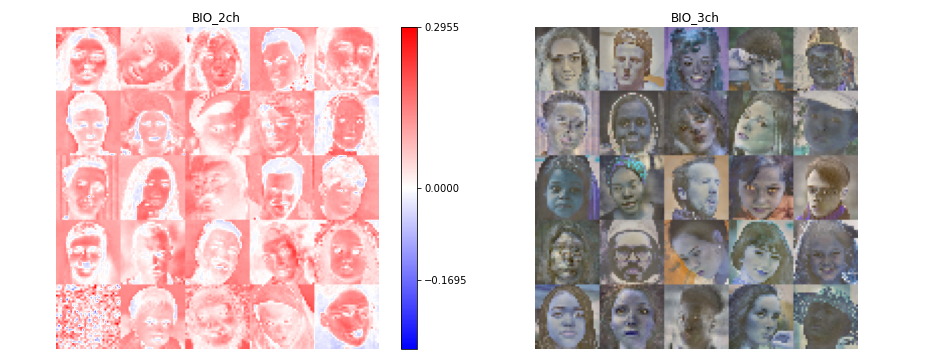

In [610]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].set_title('BIO_2ch')
ax[1].set_title('BIO_3ch')
draw_weights_2ch(synapses_2ch, Kx, Ky, -1, ax[0])
draw_weights(synapses, Kx, Ky, -1, ax[1])
plt.tight_layout()
plt.show()

In [611]:
synapses_2ch.min()
syn_list = synapses_2ch.ravel()
syn_count = np.prod(synapses_2ch.shape)
print('Number of weights:', syn_count)
nonzero_count = np.count_nonzero(synapses_2ch)
print('Number of zero weights:', syn_count-nonzero_count)
nonzero_proportion = nonzero_count/syn_count
print('Proportion of zero weights', nonzero_proportion.round(2))
negative_count = np.count_nonzero(synapses_2ch<0)
print('Negative weights count:', negative_count)
positive_count = np.count_nonzero(synapses_2ch>0)
print('Positive weights count:', positive_count)

Number of weights: 1024000
Number of zero weights: 0
Proportion of zero weights 1.0
Negative weights count: 111230
Positive weights count: 912770


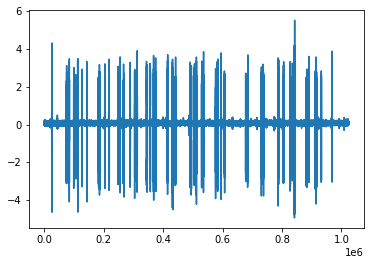

In [612]:
%matplotlib inline
plt.plot(syn_list)
plt.show()

In [613]:
synapses.min()
syn_list = synapses.ravel()
syn_count = np.prod(synapses.shape)
print('Number of weights:', syn_count)
nonzero_count = np.count_nonzero(synapses)
print('Number of zero weights:', syn_count-nonzero_count)
nonzero_proportion = nonzero_count/syn_count
print('Proportion of zero weights', nonzero_proportion.round(2))
negative_count = np.count_nonzero(synapses<0)
print('Negative weights count:', negative_count)
positive_count = np.count_nonzero(synapses>0)
print('Positive weights count:', positive_count)

Number of weights: 3072000
Number of zero weights: 0
Proportion of zero weights 1.0
Negative weights count: 1600721
Positive weights count: 1471279


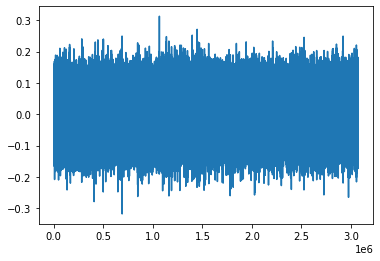

In [614]:
%matplotlib inline
plt.plot(syn_list)
plt.show()

In [615]:
def normalize(x):
    x_norm = x - x.mean(axis=1, keepdims=True)
    x_norm = x_norm / np.linalg.norm(x_norm, ord=2, axis=1, keepdims=True)
    return x_norm

## Testing: compute hidden neurons for train, val, and test data
This will be the input to the second layer, which will be trained to do real and fake face recognition.

In [616]:
# Center and normalize input data to unit vectors  
x_train0_2ch = normalize(x_train_2ch)
x_val0_2ch = normalize(x_val_2ch)
x_test0_2ch = normalize(x_test_2ch)

x_hid_train_2ch = forward(x_train0_2ch, synapses_2ch, p, N_hid, N_train_2ch, N_in_2ch, training=False)
x_hid_val_2ch = forward(x_val0_2ch, synapses_2ch, p, N_hid, N_val_2ch, N_in_2ch, training=False)
x_hid_test_2ch = forward(x_test0_2ch, synapses_2ch, p, N_hid, N_val_2ch, N_in_2ch, training=False)

n=1.5
x_hid_train_2ch = (x_hid_train_2ch * (x_hid_train_2ch>0)) ** n
x_hid_val_2ch = (x_hid_val_2ch * (x_hid_val_2ch>0)) ** n

In [617]:
# Center and normalize input data to unit vectors  
x_train0 = normalize(x_train)
x_val0 = normalize(x_val)
x_test0 = normalize(x_test)

x_hid_train = forward(x_train0, synapses, p, N_hid, N_train, N_in, training=False)
x_hid_val = forward(x_val0, synapses, p, N_hid, N_val, N_in, training=False)
x_hid_test = forward(x_test0, synapses, p, N_hid, N_val, N_in, training=False)

n=1.5
x_hid_train = (x_hid_train * (x_hid_train>0)) ** n
x_hid_val = (x_hid_val * (x_hid_val>0)) ** n

## Define the BIO model
- Input is the pre-computed hidden activations.
- Output layer is a fully connected layer with `softmax activation`
- Loss function is the `MSE`
- Optimizer is `Adam` with initial learning rate of 0.1 which decays exponentially every `20` epochs with a decay rate of `0.7`
- Batch size is `10` and number of epochs is `1000`

Set `verbose=1` in the `model.fit()` function to see the loss and accuracy values after each epoch.

In [618]:
bio_model_2ch = keras.Sequential([
    layers.Input(shape=(N_hid,)),
    layers.Dense(Nc),
    layers.Activation('softmax')
])
(bio_model_2ch.summary())
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=Nep*20, decay_rate=0.7, 
                                                          staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
bio_model_2ch.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
bio_logs_2ch = bio_model_2ch.fit(x_hid_train_2ch, y_train_2ch, validation_data=(x_hid_val_2ch, y_val_2ch), batch_size=100, 
                             epochs=1000, verbose=1)

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 2)                 2002      
_________________________________________________________________
activation_30 (Activation)   (None, 2)                 0         
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
_________________________________________________________________
Train on 1148 samples, validate on 382 samples
Epoch 1/1000
1148/1148 [==============================] - 2s 1ms/sample - loss: 0.2737 - acc: 0.5044 - val_loss: 0.2611 - val_acc: 0.5393
Epoch 2/1000
1148/1148 [==============================] - 0s 78us/sample - loss: 0.2613 - acc: 0.5305 - val_loss: 0.2561 - val_acc: 0.5497
Epoch 3/1000
1148/1148 [==============================] - 0s 76us/sample - loss: 0.2533 - acc: 0.5357 - val_loss: 0.2535 - val_acc: 0.5393
Epoch 4/1000
1148/1148 [==========================

Epoch 55/1000
1148/1148 [==============================] - 0s 55us/sample - loss: 0.2234 - acc: 0.6463 - val_loss: 0.2508 - val_acc: 0.5602
Epoch 56/1000
1148/1148 [==============================] - 0s 53us/sample - loss: 0.2233 - acc: 0.6455 - val_loss: 0.2511 - val_acc: 0.5497
Epoch 57/1000
1148/1148 [==============================] - 0s 57us/sample - loss: 0.2225 - acc: 0.6559 - val_loss: 0.2517 - val_acc: 0.5576
Epoch 58/1000
1148/1148 [==============================] - 0s 71us/sample - loss: 0.2227 - acc: 0.6568 - val_loss: 0.2511 - val_acc: 0.5576
Epoch 59/1000
1148/1148 [==============================] - 0s 56us/sample - loss: 0.2225 - acc: 0.6516 - val_loss: 0.2508 - val_acc: 0.5576
Epoch 60/1000
1148/1148 [==============================] - 0s 83us/sample - loss: 0.2224 - acc: 0.6446 - val_loss: 0.2510 - val_acc: 0.5550
Epoch 61/1000
1148/1148 [==============================] - 0s 81us/sample - loss: 0.2223 - acc: 0.6394 - val_loss: 0.2509 - val_acc: 0.5550
Epoch 62/1000
1148/1

1148/1148 [==============================] - 0s 70us/sample - loss: 0.2186 - acc: 0.6603 - val_loss: 0.2498 - val_acc: 0.5628
Epoch 114/1000
1148/1148 [==============================] - 0s 59us/sample - loss: 0.2186 - acc: 0.6585 - val_loss: 0.2494 - val_acc: 0.5628
Epoch 115/1000
1148/1148 [==============================] - 0s 57us/sample - loss: 0.2184 - acc: 0.6594 - val_loss: 0.2493 - val_acc: 0.5628
Epoch 116/1000
1148/1148 [==============================] - 0s 71us/sample - loss: 0.2185 - acc: 0.6585 - val_loss: 0.2492 - val_acc: 0.5654
Epoch 117/1000
1148/1148 [==============================] - 0s 59us/sample - loss: 0.2189 - acc: 0.6533 - val_loss: 0.2503 - val_acc: 0.5707
Epoch 118/1000
1148/1148 [==============================] - 0s 85us/sample - loss: 0.2185 - acc: 0.6655 - val_loss: 0.2496 - val_acc: 0.5550
Epoch 119/1000
1148/1148 [==============================] - 0s 57us/sample - loss: 0.2187 - acc: 0.6603 - val_loss: 0.2503 - val_acc: 0.5681
Epoch 120/1000
1148/1148 [==

1148/1148 [==============================] - 0s 60us/sample - loss: 0.2161 - acc: 0.6655 - val_loss: 0.2486 - val_acc: 0.5628
Epoch 172/1000
1148/1148 [==============================] - 0s 54us/sample - loss: 0.2153 - acc: 0.6690 - val_loss: 0.2477 - val_acc: 0.5628
Epoch 173/1000
1148/1148 [==============================] - 0s 68us/sample - loss: 0.2153 - acc: 0.6638 - val_loss: 0.2490 - val_acc: 0.5628
Epoch 174/1000
1148/1148 [==============================] - 0s 59us/sample - loss: 0.2153 - acc: 0.6655 - val_loss: 0.2482 - val_acc: 0.5681
Epoch 175/1000
1148/1148 [==============================] - 0s 53us/sample - loss: 0.2152 - acc: 0.6707 - val_loss: 0.2481 - val_acc: 0.5733
Epoch 176/1000
1148/1148 [==============================] - 0s 69us/sample - loss: 0.2154 - acc: 0.6707 - val_loss: 0.2478 - val_acc: 0.5733
Epoch 177/1000
1148/1148 [==============================] - 0s 58us/sample - loss: 0.2152 - acc: 0.6690 - val_loss: 0.2481 - val_acc: 0.5654
Epoch 178/1000
1148/1148 [==

1148/1148 [==============================] - 0s 53us/sample - loss: 0.2135 - acc: 0.6681 - val_loss: 0.2475 - val_acc: 0.5681
Epoch 230/1000
1148/1148 [==============================] - 0s 57us/sample - loss: 0.2135 - acc: 0.6690 - val_loss: 0.2485 - val_acc: 0.5628
Epoch 231/1000
1148/1148 [==============================] - 0s 72us/sample - loss: 0.2133 - acc: 0.6786 - val_loss: 0.2469 - val_acc: 0.5759
Epoch 232/1000
1148/1148 [==============================] - 0s 72us/sample - loss: 0.2131 - acc: 0.6725 - val_loss: 0.2466 - val_acc: 0.5681
Epoch 233/1000
1148/1148 [==============================] - 0s 55us/sample - loss: 0.2132 - acc: 0.6742 - val_loss: 0.2475 - val_acc: 0.5681
Epoch 234/1000
1148/1148 [==============================] - 0s 60us/sample - loss: 0.2132 - acc: 0.6681 - val_loss: 0.2480 - val_acc: 0.5681
Epoch 235/1000
1148/1148 [==============================] - 0s 59us/sample - loss: 0.2127 - acc: 0.6777 - val_loss: 0.2479 - val_acc: 0.5628
Epoch 236/1000
1148/1148 [==

1148/1148 [==============================] - 0s 57us/sample - loss: 0.2109 - acc: 0.6829 - val_loss: 0.2462 - val_acc: 0.5707
Epoch 288/1000
1148/1148 [==============================] - 0s 73us/sample - loss: 0.2110 - acc: 0.6821 - val_loss: 0.2459 - val_acc: 0.5759
Epoch 289/1000
1148/1148 [==============================] - 0s 55us/sample - loss: 0.2107 - acc: 0.6812 - val_loss: 0.2459 - val_acc: 0.5785
Epoch 290/1000
1148/1148 [==============================] - 0s 50us/sample - loss: 0.2106 - acc: 0.6812 - val_loss: 0.2464 - val_acc: 0.5785
Epoch 291/1000
1148/1148 [==============================] - 0s 60us/sample - loss: 0.2110 - acc: 0.6760 - val_loss: 0.2469 - val_acc: 0.5785
Epoch 292/1000
1148/1148 [==============================] - 0s 54us/sample - loss: 0.2104 - acc: 0.6812 - val_loss: 0.2472 - val_acc: 0.5707
Epoch 293/1000
1148/1148 [==============================] - 0s 60us/sample - loss: 0.2107 - acc: 0.6786 - val_loss: 0.2476 - val_acc: 0.5733
Epoch 294/1000
1148/1148 [==

1148/1148 [==============================] - 0s 60us/sample - loss: 0.2087 - acc: 0.6812 - val_loss: 0.2473 - val_acc: 0.5654
Epoch 346/1000
1148/1148 [==============================] - 0s 58us/sample - loss: 0.2087 - acc: 0.6899 - val_loss: 0.2469 - val_acc: 0.5628
Epoch 347/1000
1148/1148 [==============================] - 0s 50us/sample - loss: 0.2087 - acc: 0.6855 - val_loss: 0.2472 - val_acc: 0.5654
Epoch 348/1000
1148/1148 [==============================] - 0s 60us/sample - loss: 0.2086 - acc: 0.6838 - val_loss: 0.2471 - val_acc: 0.5681
Epoch 349/1000
1148/1148 [==============================] - 0s 58us/sample - loss: 0.2086 - acc: 0.6838 - val_loss: 0.2472 - val_acc: 0.5707
Epoch 350/1000
1148/1148 [==============================] - 0s 57us/sample - loss: 0.2087 - acc: 0.6847 - val_loss: 0.2475 - val_acc: 0.5681
Epoch 351/1000
1148/1148 [==============================] - 0s 59us/sample - loss: 0.2087 - acc: 0.6847 - val_loss: 0.2475 - val_acc: 0.5602
Epoch 352/1000
1148/1148 [==

1148/1148 [==============================] - 0s 69us/sample - loss: 0.2084 - acc: 0.6707 - val_loss: 0.2469 - val_acc: 0.5733
Epoch 404/1000
1148/1148 [==============================] - 0s 60us/sample - loss: 0.2076 - acc: 0.6855 - val_loss: 0.2456 - val_acc: 0.5654
Epoch 405/1000
1148/1148 [==============================] - 0s 57us/sample - loss: 0.2071 - acc: 0.6855 - val_loss: 0.2473 - val_acc: 0.5812
Epoch 406/1000
1148/1148 [==============================] - 0s 68us/sample - loss: 0.2075 - acc: 0.6890 - val_loss: 0.2459 - val_acc: 0.5628
Epoch 407/1000
1148/1148 [==============================] - 0s 60us/sample - loss: 0.2069 - acc: 0.6873 - val_loss: 0.2461 - val_acc: 0.5785
Epoch 408/1000
1148/1148 [==============================] - 0s 58us/sample - loss: 0.2069 - acc: 0.6925 - val_loss: 0.2466 - val_acc: 0.5628
Epoch 409/1000
1148/1148 [==============================] - 0s 49us/sample - loss: 0.2067 - acc: 0.6916 - val_loss: 0.2466 - val_acc: 0.5733
Epoch 410/1000
1148/1148 [==

1148/1148 [==============================] - 0s 58us/sample - loss: 0.2053 - acc: 0.6934 - val_loss: 0.2467 - val_acc: 0.5812
Epoch 462/1000
1148/1148 [==============================] - 0s 66us/sample - loss: 0.2052 - acc: 0.6951 - val_loss: 0.2463 - val_acc: 0.5759
Epoch 463/1000
1148/1148 [==============================] - 0s 76us/sample - loss: 0.2051 - acc: 0.6925 - val_loss: 0.2462 - val_acc: 0.5785
Epoch 464/1000
1148/1148 [==============================] - 0s 53us/sample - loss: 0.2052 - acc: 0.6916 - val_loss: 0.2453 - val_acc: 0.5942
Epoch 465/1000
1148/1148 [==============================] - 0s 48us/sample - loss: 0.2050 - acc: 0.6943 - val_loss: 0.2452 - val_acc: 0.5890
Epoch 466/1000
1148/1148 [==============================] - 0s 58us/sample - loss: 0.2049 - acc: 0.6899 - val_loss: 0.2466 - val_acc: 0.5864
Epoch 467/1000
1148/1148 [==============================] - 0s 52us/sample - loss: 0.2053 - acc: 0.6916 - val_loss: 0.2463 - val_acc: 0.5707
Epoch 468/1000
1148/1148 [==

1148/1148 [==============================] - 0s 65us/sample - loss: 0.2035 - acc: 0.6977 - val_loss: 0.2459 - val_acc: 0.5733
Epoch 520/1000
1148/1148 [==============================] - 0s 57us/sample - loss: 0.2035 - acc: 0.6960 - val_loss: 0.2468 - val_acc: 0.5681
Epoch 521/1000
1148/1148 [==============================] - 0s 52us/sample - loss: 0.2036 - acc: 0.6986 - val_loss: 0.2465 - val_acc: 0.5707
Epoch 522/1000
1148/1148 [==============================] - 0s 59us/sample - loss: 0.2036 - acc: 0.6943 - val_loss: 0.2462 - val_acc: 0.5681
Epoch 523/1000
1148/1148 [==============================] - 0s 64us/sample - loss: 0.2034 - acc: 0.6995 - val_loss: 0.2458 - val_acc: 0.5838
Epoch 524/1000
1148/1148 [==============================] - 0s 73us/sample - loss: 0.2032 - acc: 0.6969 - val_loss: 0.2456 - val_acc: 0.5759
Epoch 525/1000
1148/1148 [==============================] - 0s 75us/sample - loss: 0.2033 - acc: 0.6960 - val_loss: 0.2467 - val_acc: 0.5759
Epoch 526/1000
1148/1148 [==

1148/1148 [==============================] - 0s 63us/sample - loss: 0.2018 - acc: 0.6986 - val_loss: 0.2450 - val_acc: 0.5864
Epoch 578/1000
1148/1148 [==============================] - 0s 66us/sample - loss: 0.2022 - acc: 0.7003 - val_loss: 0.2447 - val_acc: 0.5785
Epoch 579/1000
1148/1148 [==============================] - 0s 64us/sample - loss: 0.2018 - acc: 0.6995 - val_loss: 0.2456 - val_acc: 0.5759
Epoch 580/1000
1148/1148 [==============================] - 0s 66us/sample - loss: 0.2021 - acc: 0.7012 - val_loss: 0.2455 - val_acc: 0.5864
Epoch 581/1000
1148/1148 [==============================] - 0s 58us/sample - loss: 0.2021 - acc: 0.7003 - val_loss: 0.2450 - val_acc: 0.5785
Epoch 582/1000
1148/1148 [==============================] - 0s 54us/sample - loss: 0.2017 - acc: 0.6977 - val_loss: 0.2452 - val_acc: 0.5838
Epoch 583/1000
1148/1148 [==============================] - 0s 56us/sample - loss: 0.2018 - acc: 0.6986 - val_loss: 0.2452 - val_acc: 0.5838
Epoch 584/1000
1148/1148 [==

1148/1148 [==============================] - 0s 68us/sample - loss: 0.2005 - acc: 0.7082 - val_loss: 0.2445 - val_acc: 0.5864
Epoch 636/1000
1148/1148 [==============================] - 0s 72us/sample - loss: 0.2003 - acc: 0.7064 - val_loss: 0.2446 - val_acc: 0.5864
Epoch 637/1000
1148/1148 [==============================] - 0s 72us/sample - loss: 0.2005 - acc: 0.7056 - val_loss: 0.2447 - val_acc: 0.5812
Epoch 638/1000
1148/1148 [==============================] - 0s 66us/sample - loss: 0.2000 - acc: 0.7047 - val_loss: 0.2445 - val_acc: 0.5864
Epoch 639/1000
1148/1148 [==============================] - 0s 73us/sample - loss: 0.2002 - acc: 0.7030 - val_loss: 0.2442 - val_acc: 0.5890
Epoch 640/1000
1148/1148 [==============================] - 0s 64us/sample - loss: 0.2002 - acc: 0.7021 - val_loss: 0.2448 - val_acc: 0.5916
Epoch 641/1000
1148/1148 [==============================] - 0s 68us/sample - loss: 0.2002 - acc: 0.7047 - val_loss: 0.2451 - val_acc: 0.5707
Epoch 642/1000
1148/1148 [==

1148/1148 [==============================] - 0s 48us/sample - loss: 0.1994 - acc: 0.7012 - val_loss: 0.2452 - val_acc: 0.5838
Epoch 694/1000
1148/1148 [==============================] - 0s 59us/sample - loss: 0.1990 - acc: 0.7099 - val_loss: 0.2462 - val_acc: 0.5785
Epoch 695/1000
1148/1148 [==============================] - 0s 59us/sample - loss: 0.1989 - acc: 0.7064 - val_loss: 0.2466 - val_acc: 0.5812
Epoch 696/1000
1148/1148 [==============================] - 0s 63us/sample - loss: 0.1988 - acc: 0.7091 - val_loss: 0.2462 - val_acc: 0.5785
Epoch 697/1000
1148/1148 [==============================] - 0s 70us/sample - loss: 0.1987 - acc: 0.7082 - val_loss: 0.2452 - val_acc: 0.5890
Epoch 698/1000
1148/1148 [==============================] - 0s 62us/sample - loss: 0.1986 - acc: 0.7099 - val_loss: 0.2453 - val_acc: 0.5812
Epoch 699/1000
1148/1148 [==============================] - 0s 62us/sample - loss: 0.1986 - acc: 0.7099 - val_loss: 0.2452 - val_acc: 0.5838
Epoch 700/1000
1148/1148 [==

1148/1148 [==============================] - 0s 49us/sample - loss: 0.1976 - acc: 0.7056 - val_loss: 0.2448 - val_acc: 0.5838
Epoch 752/1000
1148/1148 [==============================] - 0s 72us/sample - loss: 0.1975 - acc: 0.7108 - val_loss: 0.2452 - val_acc: 0.5890
Epoch 753/1000
1148/1148 [==============================] - 0s 54us/sample - loss: 0.1975 - acc: 0.7134 - val_loss: 0.2451 - val_acc: 0.5864
Epoch 754/1000
1148/1148 [==============================] - 0s 71us/sample - loss: 0.1973 - acc: 0.7125 - val_loss: 0.2450 - val_acc: 0.5890
Epoch 755/1000
1148/1148 [==============================] - 0s 52us/sample - loss: 0.1977 - acc: 0.7064 - val_loss: 0.2438 - val_acc: 0.5864
Epoch 756/1000
1148/1148 [==============================] - 0s 84us/sample - loss: 0.1975 - acc: 0.7108 - val_loss: 0.2440 - val_acc: 0.5890
Epoch 757/1000
1148/1148 [==============================] - 0s 70us/sample - loss: 0.1973 - acc: 0.7186 - val_loss: 0.2443 - val_acc: 0.5864
Epoch 758/1000
1148/1148 [==

1148/1148 [==============================] - 0s 59us/sample - loss: 0.1960 - acc: 0.7073 - val_loss: 0.2439 - val_acc: 0.5942
Epoch 810/1000
1148/1148 [==============================] - 0s 48us/sample - loss: 0.1968 - acc: 0.7134 - val_loss: 0.2439 - val_acc: 0.5969
Epoch 811/1000
1148/1148 [==============================] - 0s 82us/sample - loss: 0.1961 - acc: 0.7143 - val_loss: 0.2452 - val_acc: 0.5759
Epoch 812/1000
1148/1148 [==============================] - 0s 49us/sample - loss: 0.1960 - acc: 0.7178 - val_loss: 0.2449 - val_acc: 0.5733
Epoch 813/1000
1148/1148 [==============================] - 0s 48us/sample - loss: 0.1965 - acc: 0.7186 - val_loss: 0.2448 - val_acc: 0.5838
Epoch 814/1000
1148/1148 [==============================] - 0s 56us/sample - loss: 0.1960 - acc: 0.7134 - val_loss: 0.2449 - val_acc: 0.5838
Epoch 815/1000
1148/1148 [==============================] - 0s 49us/sample - loss: 0.1961 - acc: 0.7117 - val_loss: 0.2442 - val_acc: 0.5838
Epoch 816/1000
1148/1148 [==

1148/1148 [==============================] - 0s 62us/sample - loss: 0.1949 - acc: 0.7195 - val_loss: 0.2445 - val_acc: 0.5785
Epoch 868/1000
1148/1148 [==============================] - 0s 60us/sample - loss: 0.1951 - acc: 0.7152 - val_loss: 0.2447 - val_acc: 0.5838
Epoch 869/1000
1148/1148 [==============================] - 0s 48us/sample - loss: 0.1947 - acc: 0.7178 - val_loss: 0.2448 - val_acc: 0.5838
Epoch 870/1000
1148/1148 [==============================] - 0s 48us/sample - loss: 0.1947 - acc: 0.7213 - val_loss: 0.2453 - val_acc: 0.5707
Epoch 871/1000
1148/1148 [==============================] - 0s 48us/sample - loss: 0.1947 - acc: 0.7204 - val_loss: 0.2450 - val_acc: 0.5681
Epoch 872/1000
1148/1148 [==============================] - 0s 58us/sample - loss: 0.1951 - acc: 0.7247 - val_loss: 0.2449 - val_acc: 0.5812
Epoch 873/1000
1148/1148 [==============================] - 0s 58us/sample - loss: 0.1947 - acc: 0.7117 - val_loss: 0.2450 - val_acc: 0.5864
Epoch 874/1000
1148/1148 [==

1148/1148 [==============================] - 0s 49us/sample - loss: 0.1932 - acc: 0.7186 - val_loss: 0.2444 - val_acc: 0.5916
Epoch 926/1000
1148/1148 [==============================] - 0s 49us/sample - loss: 0.1939 - acc: 0.7239 - val_loss: 0.2446 - val_acc: 0.5942
Epoch 927/1000
1148/1148 [==============================] - 0s 77us/sample - loss: 0.1932 - acc: 0.7213 - val_loss: 0.2445 - val_acc: 0.5864
Epoch 928/1000
1148/1148 [==============================] - 0s 70us/sample - loss: 0.1935 - acc: 0.7186 - val_loss: 0.2438 - val_acc: 0.5942
Epoch 929/1000
1148/1148 [==============================] - 0s 48us/sample - loss: 0.1934 - acc: 0.7204 - val_loss: 0.2444 - val_acc: 0.5812
Epoch 930/1000
1148/1148 [==============================] - 0s 49us/sample - loss: 0.1939 - acc: 0.7143 - val_loss: 0.2443 - val_acc: 0.5890
Epoch 931/1000
1148/1148 [==============================] - 0s 60us/sample - loss: 0.1935 - acc: 0.7247 - val_loss: 0.2448 - val_acc: 0.5838
Epoch 932/1000
1148/1148 [==

1148/1148 [==============================] - 0s 58us/sample - loss: 0.1925 - acc: 0.7239 - val_loss: 0.2444 - val_acc: 0.5916
Epoch 984/1000
1148/1148 [==============================] - 0s 61us/sample - loss: 0.1925 - acc: 0.7204 - val_loss: 0.2448 - val_acc: 0.5916
Epoch 985/1000
1148/1148 [==============================] - 0s 80us/sample - loss: 0.1924 - acc: 0.7213 - val_loss: 0.2436 - val_acc: 0.5890
Epoch 986/1000
1148/1148 [==============================] - 0s 73us/sample - loss: 0.1921 - acc: 0.7265 - val_loss: 0.2445 - val_acc: 0.5890
Epoch 987/1000
1148/1148 [==============================] - 0s 49us/sample - loss: 0.1921 - acc: 0.7221 - val_loss: 0.2444 - val_acc: 0.5995
Epoch 988/1000
1148/1148 [==============================] - 0s 53us/sample - loss: 0.1922 - acc: 0.7204 - val_loss: 0.2449 - val_acc: 0.5916
Epoch 989/1000
1148/1148 [==============================] - 0s 48us/sample - loss: 0.1921 - acc: 0.7239 - val_loss: 0.2448 - val_acc: 0.5838
Epoch 990/1000
1148/1148 [==

In [619]:
bio_model = keras.Sequential([
    layers.Input(shape=(N_hid,)),
    layers.Dense(Nc),
    layers.Activation('softmax')
])
print(bio_model.summary())

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=4e-3, decay_steps=Nep*20, decay_rate=0.7, 
                                                          staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
bio_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
bio_logs = bio_model.fit(x_hid_train, y_train, validation_data=(x_hid_val, y_val), batch_size=100, epochs=1000, verbose=1)

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_137 (Dense)            (None, 2)                 2002      
_________________________________________________________________
activation_31 (Activation)   (None, 2)                 0         
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 1148 samples, validate on 382 samples
Epoch 1/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.2497 - acc: 0.5044 - val_loss: 0.2466 - val_acc: 0.5707
Epoch 2/1000
1148/1148 [==============================] - 0s 90us/sample - loss: 0.2470 - acc: 0.5497 - val_loss: 0.2445 - val_acc: 0.5707
Epoch 3/1000
1148/1148 [==============================] - 0s 95us/sample - loss: 0.2451 - acc: 0.5871 - val_loss: 0.2431 - val_acc: 0.5812
Epoch 4/1000
1148/1148 [=====================

1148/1148 [==============================] - 0s 95us/sample - loss: 0.2144 - acc: 0.6638 - val_loss: 0.2302 - val_acc: 0.6099
Epoch 55/1000
1148/1148 [==============================] - 0s 92us/sample - loss: 0.2142 - acc: 0.6638 - val_loss: 0.2308 - val_acc: 0.6047
Epoch 56/1000
1148/1148 [==============================] - 0s 97us/sample - loss: 0.2140 - acc: 0.6699 - val_loss: 0.2300 - val_acc: 0.6099
Epoch 57/1000
1148/1148 [==============================] - 0s 96us/sample - loss: 0.2138 - acc: 0.6681 - val_loss: 0.2315 - val_acc: 0.6152
Epoch 58/1000
1148/1148 [==============================] - 0s 92us/sample - loss: 0.2132 - acc: 0.6716 - val_loss: 0.2303 - val_acc: 0.6099
Epoch 59/1000
1148/1148 [==============================] - 0s 94us/sample - loss: 0.2128 - acc: 0.6742 - val_loss: 0.2301 - val_acc: 0.6126
Epoch 60/1000
1148/1148 [==============================] - 0s 92us/sample - loss: 0.2125 - acc: 0.6733 - val_loss: 0.2305 - val_acc: 0.6099
Epoch 61/1000
1148/1148 [=========

1148/1148 [==============================] - 0s 94us/sample - loss: 0.1987 - acc: 0.7160 - val_loss: 0.2311 - val_acc: 0.6152
Epoch 113/1000
1148/1148 [==============================] - 0s 87us/sample - loss: 0.1985 - acc: 0.7195 - val_loss: 0.2315 - val_acc: 0.5995
Epoch 114/1000
1148/1148 [==============================] - 0s 90us/sample - loss: 0.1983 - acc: 0.7195 - val_loss: 0.2316 - val_acc: 0.5995
Epoch 115/1000
1148/1148 [==============================] - 0s 90us/sample - loss: 0.1980 - acc: 0.7186 - val_loss: 0.2316 - val_acc: 0.6073
Epoch 116/1000
1148/1148 [==============================] - 0s 92us/sample - loss: 0.1978 - acc: 0.7221 - val_loss: 0.2321 - val_acc: 0.5995
Epoch 117/1000
1148/1148 [==============================] - 0s 94us/sample - loss: 0.1978 - acc: 0.7204 - val_loss: 0.2313 - val_acc: 0.6073
Epoch 118/1000
1148/1148 [==============================] - 0s 91us/sample - loss: 0.1975 - acc: 0.7230 - val_loss: 0.2312 - val_acc: 0.6099
Epoch 119/1000
1148/1148 [==

1148/1148 [==============================] - 0s 91us/sample - loss: 0.1869 - acc: 0.7596 - val_loss: 0.2333 - val_acc: 0.6073
Epoch 171/1000
1148/1148 [==============================] - 0s 97us/sample - loss: 0.1867 - acc: 0.7578 - val_loss: 0.2336 - val_acc: 0.6099
Epoch 172/1000
1148/1148 [==============================] - 0s 95us/sample - loss: 0.1867 - acc: 0.7596 - val_loss: 0.2330 - val_acc: 0.6126
Epoch 173/1000
1148/1148 [==============================] - 0s 86us/sample - loss: 0.1863 - acc: 0.7578 - val_loss: 0.2331 - val_acc: 0.6047
Epoch 174/1000
1148/1148 [==============================] - 0s 92us/sample - loss: 0.1861 - acc: 0.7578 - val_loss: 0.2335 - val_acc: 0.6099
Epoch 175/1000
1148/1148 [==============================] - 0s 98us/sample - loss: 0.1862 - acc: 0.7561 - val_loss: 0.2341 - val_acc: 0.6073
Epoch 176/1000
1148/1148 [==============================] - 0s 92us/sample - loss: 0.1858 - acc: 0.7613 - val_loss: 0.2327 - val_acc: 0.6047
Epoch 177/1000
1148/1148 [==

1148/1148 [==============================] - 0s 106us/sample - loss: 0.1772 - acc: 0.7761 - val_loss: 0.2362 - val_acc: 0.6073
Epoch 229/1000
1148/1148 [==============================] - 0s 116us/sample - loss: 0.1771 - acc: 0.7796 - val_loss: 0.2362 - val_acc: 0.6099
Epoch 230/1000
1148/1148 [==============================] - 0s 101us/sample - loss: 0.1768 - acc: 0.7848 - val_loss: 0.2357 - val_acc: 0.6099
Epoch 231/1000
1148/1148 [==============================] - 0s 103us/sample - loss: 0.1767 - acc: 0.7805 - val_loss: 0.2356 - val_acc: 0.6099
Epoch 232/1000
1148/1148 [==============================] - 0s 104us/sample - loss: 0.1766 - acc: 0.7805 - val_loss: 0.2361 - val_acc: 0.6073
Epoch 233/1000
1148/1148 [==============================] - 0s 110us/sample - loss: 0.1764 - acc: 0.7814 - val_loss: 0.2358 - val_acc: 0.6099
Epoch 234/1000
1148/1148 [==============================] - 0s 108us/sample - loss: 0.1764 - acc: 0.7814 - val_loss: 0.2354 - val_acc: 0.6047
Epoch 235/1000
1148/1

Epoch 286/1000
1148/1148 [==============================] - 0s 88us/sample - loss: 0.1693 - acc: 0.7936 - val_loss: 0.2386 - val_acc: 0.5916
Epoch 287/1000
1148/1148 [==============================] - 0s 86us/sample - loss: 0.1689 - acc: 0.7970 - val_loss: 0.2376 - val_acc: 0.6021
Epoch 288/1000
1148/1148 [==============================] - 0s 123us/sample - loss: 0.1687 - acc: 0.7953 - val_loss: 0.2369 - val_acc: 0.6099
Epoch 289/1000
1148/1148 [==============================] - 0s 100us/sample - loss: 0.1687 - acc: 0.7953 - val_loss: 0.2369 - val_acc: 0.6099
Epoch 290/1000
1148/1148 [==============================] - 0s 92us/sample - loss: 0.1685 - acc: 0.7988 - val_loss: 0.2379 - val_acc: 0.5995
Epoch 291/1000
1148/1148 [==============================] - 0s 92us/sample - loss: 0.1686 - acc: 0.7970 - val_loss: 0.2383 - val_acc: 0.6021
Epoch 292/1000
1148/1148 [==============================] - 0s 98us/sample - loss: 0.1682 - acc: 0.7953 - val_loss: 0.2380 - val_acc: 0.6047
Epoch 293/1

1148/1148 [==============================] - 0s 108us/sample - loss: 0.1621 - acc: 0.8075 - val_loss: 0.2391 - val_acc: 0.6047
Epoch 344/1000
1148/1148 [==============================] - 0s 106us/sample - loss: 0.1620 - acc: 0.8040 - val_loss: 0.2396 - val_acc: 0.6047
Epoch 345/1000
1148/1148 [==============================] - 0s 108us/sample - loss: 0.1618 - acc: 0.8049 - val_loss: 0.2397 - val_acc: 0.6047
Epoch 346/1000
1148/1148 [==============================] - 0s 110us/sample - loss: 0.1617 - acc: 0.8049 - val_loss: 0.2393 - val_acc: 0.6021
Epoch 347/1000
1148/1148 [==============================] - 0s 116us/sample - loss: 0.1618 - acc: 0.8066 - val_loss: 0.2389 - val_acc: 0.6073
Epoch 348/1000
1148/1148 [==============================] - 0s 103us/sample - loss: 0.1615 - acc: 0.8075 - val_loss: 0.2398 - val_acc: 0.6021
Epoch 349/1000
1148/1148 [==============================] - 0s 91us/sample - loss: 0.1613 - acc: 0.8049 - val_loss: 0.2403 - val_acc: 0.6021
Epoch 350/1000
1148/11

Epoch 401/1000
1148/1148 [==============================] - 0s 106us/sample - loss: 0.1557 - acc: 0.8136 - val_loss: 0.2408 - val_acc: 0.5942
Epoch 402/1000
1148/1148 [==============================] - 0s 96us/sample - loss: 0.1556 - acc: 0.8171 - val_loss: 0.2411 - val_acc: 0.5916
Epoch 403/1000
1148/1148 [==============================] - 0s 102us/sample - loss: 0.1556 - acc: 0.8145 - val_loss: 0.2409 - val_acc: 0.5916
Epoch 404/1000
1148/1148 [==============================] - 0s 109us/sample - loss: 0.1553 - acc: 0.8162 - val_loss: 0.2412 - val_acc: 0.6021
Epoch 405/1000
1148/1148 [==============================] - 0s 108us/sample - loss: 0.1554 - acc: 0.8179 - val_loss: 0.2418 - val_acc: 0.5890
Epoch 406/1000
1148/1148 [==============================] - 0s 108us/sample - loss: 0.1554 - acc: 0.8171 - val_loss: 0.2419 - val_acc: 0.5864
Epoch 407/1000
1148/1148 [==============================] - 0s 95us/sample - loss: 0.1552 - acc: 0.8206 - val_loss: 0.2416 - val_acc: 0.5838
Epoch 40

Epoch 459/1000
1148/1148 [==============================] - 0s 88us/sample - loss: 0.1501 - acc: 0.8275 - val_loss: 0.2430 - val_acc: 0.5890
Epoch 460/1000
1148/1148 [==============================] - 0s 87us/sample - loss: 0.1499 - acc: 0.8284 - val_loss: 0.2426 - val_acc: 0.5838
Epoch 461/1000
1148/1148 [==============================] - 0s 85us/sample - loss: 0.1499 - acc: 0.8258 - val_loss: 0.2421 - val_acc: 0.5916
Epoch 462/1000
1148/1148 [==============================] - 0s 87us/sample - loss: 0.1498 - acc: 0.8284 - val_loss: 0.2430 - val_acc: 0.5838
Epoch 463/1000
1148/1148 [==============================] - ETA: 0s - loss: 0.1482 - acc: 0.833 - 0s 85us/sample - loss: 0.1497 - acc: 0.8267 - val_loss: 0.2431 - val_acc: 0.5890
Epoch 464/1000
1148/1148 [==============================] - 0s 86us/sample - loss: 0.1497 - acc: 0.8293 - val_loss: 0.2426 - val_acc: 0.5785
Epoch 465/1000
1148/1148 [==============================] - 0s 84us/sample - loss: 0.1495 - acc: 0.8275 - val_loss: 

1148/1148 [==============================] - 0s 85us/sample - loss: 0.1449 - acc: 0.8310 - val_loss: 0.2447 - val_acc: 0.5785
Epoch 517/1000
1148/1148 [==============================] - 0s 87us/sample - loss: 0.1448 - acc: 0.8328 - val_loss: 0.2445 - val_acc: 0.5812
Epoch 518/1000
1148/1148 [==============================] - 0s 88us/sample - loss: 0.1447 - acc: 0.8336 - val_loss: 0.2445 - val_acc: 0.5785
Epoch 519/1000
1148/1148 [==============================] - ETA: 0s - loss: 0.1449 - acc: 0.831 - 0s 84us/sample - loss: 0.1446 - acc: 0.8319 - val_loss: 0.2447 - val_acc: 0.5785
Epoch 520/1000
1148/1148 [==============================] - 0s 89us/sample - loss: 0.1446 - acc: 0.8319 - val_loss: 0.2446 - val_acc: 0.5812
Epoch 521/1000
1148/1148 [==============================] - 0s 87us/sample - loss: 0.1445 - acc: 0.8301 - val_loss: 0.2446 - val_acc: 0.5785
Epoch 522/1000
1148/1148 [==============================] - 0s 85us/sample - loss: 0.1446 - acc: 0.8345 - val_loss: 0.2441 - val_ac

Epoch 573/1000
1148/1148 [==============================] - 0s 91us/sample - loss: 0.1403 - acc: 0.8406 - val_loss: 0.2463 - val_acc: 0.5654
Epoch 574/1000
1148/1148 [==============================] - 0s 85us/sample - loss: 0.1402 - acc: 0.8441 - val_loss: 0.2457 - val_acc: 0.5785
Epoch 575/1000
1148/1148 [==============================] - 0s 87us/sample - loss: 0.1401 - acc: 0.8441 - val_loss: 0.2459 - val_acc: 0.5785
Epoch 576/1000
1148/1148 [==============================] - 0s 85us/sample - loss: 0.1400 - acc: 0.8423 - val_loss: 0.2466 - val_acc: 0.5654
Epoch 577/1000
1148/1148 [==============================] - 0s 89us/sample - loss: 0.1399 - acc: 0.8441 - val_loss: 0.2459 - val_acc: 0.5759
Epoch 578/1000
1148/1148 [==============================] - ETA: 0s - loss: 0.1406 - acc: 0.836 - 0s 84us/sample - loss: 0.1400 - acc: 0.8397 - val_loss: 0.2460 - val_acc: 0.5785
Epoch 579/1000
1148/1148 [==============================] - 0s 85us/sample - loss: 0.1399 - acc: 0.8441 - val_loss: 

Epoch 630/1000
1148/1148 [==============================] - 0s 84us/sample - loss: 0.1360 - acc: 0.8528 - val_loss: 0.2482 - val_acc: 0.5681
Epoch 631/1000
1148/1148 [==============================] - 0s 86us/sample - loss: 0.1359 - acc: 0.8537 - val_loss: 0.2477 - val_acc: 0.5707
Epoch 632/1000
1148/1148 [==============================] - 0s 89us/sample - loss: 0.1359 - acc: 0.8528 - val_loss: 0.2470 - val_acc: 0.5759
Epoch 633/1000
1148/1148 [==============================] - 0s 85us/sample - loss: 0.1357 - acc: 0.8537 - val_loss: 0.2474 - val_acc: 0.5654
Epoch 634/1000
1148/1148 [==============================] - 0s 84us/sample - loss: 0.1357 - acc: 0.8510 - val_loss: 0.2474 - val_acc: 0.5707
Epoch 635/1000
1148/1148 [==============================] - ETA: 0s - loss: 0.1341 - acc: 0.865 - 0s 88us/sample - loss: 0.1356 - acc: 0.8563 - val_loss: 0.2478 - val_acc: 0.5681
Epoch 636/1000
1148/1148 [==============================] - 0s 87us/sample - loss: 0.1356 - acc: 0.8554 - val_loss: 

1148/1148 [==============================] - 0s 87us/sample - loss: 0.1320 - acc: 0.8632 - val_loss: 0.2493 - val_acc: 0.5654
Epoch 687/1000
1148/1148 [==============================] - 0s 84us/sample - loss: 0.1320 - acc: 0.8624 - val_loss: 0.2490 - val_acc: 0.5681
Epoch 688/1000
1148/1148 [==============================] - 0s 87us/sample - loss: 0.1319 - acc: 0.8650 - val_loss: 0.2488 - val_acc: 0.5681
Epoch 689/1000
1148/1148 [==============================] - 0s 88us/sample - loss: 0.1318 - acc: 0.8650 - val_loss: 0.2488 - val_acc: 0.5602
Epoch 690/1000
1148/1148 [==============================] - 0s 88us/sample - loss: 0.1318 - acc: 0.8624 - val_loss: 0.2491 - val_acc: 0.5602
Epoch 691/1000
1148/1148 [==============================] - ETA: 0s - loss: 0.1316 - acc: 0.866 - 0s 88us/sample - loss: 0.1317 - acc: 0.8632 - val_loss: 0.2489 - val_acc: 0.5602
Epoch 692/1000
1148/1148 [==============================] - 0s 84us/sample - loss: 0.1317 - acc: 0.8624 - val_loss: 0.2488 - val_ac

1148/1148 [==============================] - 0s 84us/sample - loss: 0.1284 - acc: 0.8702 - val_loss: 0.2497 - val_acc: 0.5707
Epoch 744/1000
1148/1148 [==============================] - 0s 78us/sample - loss: 0.1283 - acc: 0.8711 - val_loss: 0.2496 - val_acc: 0.5759
Epoch 745/1000
1148/1148 [==============================] - ETA: 0s - loss: 0.1267 - acc: 0.872 - 0s 87us/sample - loss: 0.1283 - acc: 0.8702 - val_loss: 0.2507 - val_acc: 0.5602
Epoch 746/1000
1148/1148 [==============================] - 0s 85us/sample - loss: 0.1282 - acc: 0.8720 - val_loss: 0.2502 - val_acc: 0.5654
Epoch 747/1000
1148/1148 [==============================] - 0s 87us/sample - loss: 0.1284 - acc: 0.8737 - val_loss: 0.2497 - val_acc: 0.5733
Epoch 748/1000
1148/1148 [==============================] - 0s 86us/sample - loss: 0.1281 - acc: 0.8737 - val_loss: 0.2509 - val_acc: 0.5602
Epoch 749/1000
1148/1148 [==============================] - 0s 90us/sample - loss: 0.1281 - acc: 0.8728 - val_loss: 0.2513 - val_ac

Epoch 801/1000
1148/1148 [==============================] - 0s 84us/sample - loss: 0.1249 - acc: 0.8772 - val_loss: 0.2514 - val_acc: 0.5628
Epoch 802/1000
1148/1148 [==============================] - 0s 87us/sample - loss: 0.1248 - acc: 0.8780 - val_loss: 0.2519 - val_acc: 0.5550
Epoch 803/1000
1148/1148 [==============================] - 0s 85us/sample - loss: 0.1248 - acc: 0.8772 - val_loss: 0.2512 - val_acc: 0.5628
Epoch 804/1000
1148/1148 [==============================] - 0s 89us/sample - loss: 0.1248 - acc: 0.8780 - val_loss: 0.2520 - val_acc: 0.5654
Epoch 805/1000
1148/1148 [==============================] - 0s 80us/sample - loss: 0.1246 - acc: 0.8789 - val_loss: 0.2513 - val_acc: 0.5628
Epoch 806/1000
1148/1148 [==============================] - 0s 86us/sample - loss: 0.1245 - acc: 0.8754 - val_loss: 0.2512 - val_acc: 0.5628
Epoch 807/1000
1148/1148 [==============================] - 0s 90us/sample - loss: 0.1245 - acc: 0.8807 - val_loss: 0.2514 - val_acc: 0.5602
Epoch 808/100

Epoch 859/1000
1148/1148 [==============================] - 0s 89us/sample - loss: 0.1215 - acc: 0.8824 - val_loss: 0.2533 - val_acc: 0.5628
Epoch 860/1000
1148/1148 [==============================] - 0s 93us/sample - loss: 0.1216 - acc: 0.8798 - val_loss: 0.2526 - val_acc: 0.5628
Epoch 861/1000
1148/1148 [==============================] - 0s 94us/sample - loss: 0.1214 - acc: 0.8798 - val_loss: 0.2531 - val_acc: 0.5628
Epoch 862/1000
1148/1148 [==============================] - 0s 88us/sample - loss: 0.1213 - acc: 0.8807 - val_loss: 0.2534 - val_acc: 0.5654
Epoch 863/1000
1148/1148 [==============================] - 0s 106us/sample - loss: 0.1213 - acc: 0.8807 - val_loss: 0.2527 - val_acc: 0.5628
Epoch 864/1000
1148/1148 [==============================] - ETA: 0s - loss: 0.1206 - acc: 0.877 - 0s 106us/sample - loss: 0.1213 - acc: 0.8815 - val_loss: 0.2528 - val_acc: 0.5628
Epoch 865/1000
1148/1148 [==============================] - 0s 103us/sample - loss: 0.1212 - acc: 0.8815 - val_los

1148/1148 [==============================] - 0s 94us/sample - loss: 0.1184 - acc: 0.8868 - val_loss: 0.2543 - val_acc: 0.5628
Epoch 917/1000
1148/1148 [==============================] - 0s 103us/sample - loss: 0.1184 - acc: 0.8859 - val_loss: 0.2545 - val_acc: 0.5602
Epoch 918/1000
1148/1148 [==============================] - 0s 109us/sample - loss: 0.1184 - acc: 0.8868 - val_loss: 0.2543 - val_acc: 0.5602
Epoch 919/1000
1148/1148 [==============================] - 0s 102us/sample - loss: 0.1183 - acc: 0.8876 - val_loss: 0.2544 - val_acc: 0.5628
Epoch 920/1000
1148/1148 [==============================] - 0s 105us/sample - loss: 0.1183 - acc: 0.8859 - val_loss: 0.2548 - val_acc: 0.5602
Epoch 921/1000
1148/1148 [==============================] - 0s 110us/sample - loss: 0.1182 - acc: 0.8885 - val_loss: 0.2544 - val_acc: 0.5602
Epoch 922/1000
1148/1148 [==============================] - 0s 104us/sample - loss: 0.1181 - acc: 0.8894 - val_loss: 0.2543 - val_acc: 0.5628
Epoch 923/1000
1148/11

1148/1148 [==============================] - 0s 95us/sample - loss: 0.1155 - acc: 0.8902 - val_loss: 0.2556 - val_acc: 0.5628
Epoch 974/1000
1148/1148 [==============================] - 0s 92us/sample - loss: 0.1156 - acc: 0.8885 - val_loss: 0.2561 - val_acc: 0.5628
Epoch 975/1000
1148/1148 [==============================] - 0s 97us/sample - loss: 0.1156 - acc: 0.8937 - val_loss: 0.2552 - val_acc: 0.5628
Epoch 976/1000
1148/1148 [==============================] - 0s 95us/sample - loss: 0.1154 - acc: 0.8937 - val_loss: 0.2556 - val_acc: 0.5628
Epoch 977/1000
1148/1148 [==============================] - 0s 94us/sample - loss: 0.1155 - acc: 0.8937 - val_loss: 0.2568 - val_acc: 0.5576
Epoch 978/1000
1148/1148 [==============================] - 0s 100us/sample - loss: 0.1153 - acc: 0.8920 - val_loss: 0.2557 - val_acc: 0.5654
Epoch 979/1000
1148/1148 [==============================] - 0s 104us/sample - loss: 0.1152 - acc: 0.8937 - val_loss: 0.2554 - val_acc: 0.5654
Epoch 980/1000
1148/1148 [

## Define the backprop model
- One fully-connected hidden layer with the same number of neurons as the BIO model, i.e. `N_hid`
    - Activation is 'relu'
- Another fully-connected output layer with softmax activation
- Same loss and optimizer as BIO

In [620]:
bp_model_2ch = keras.Sequential([
    layers.Input(shape=(N_in_2ch,)),
    layers.Dense(N_hid),
    layers.Activation("relu"),
    layers.Dense(Nc, activation="softmax")
])
print(bp_model_2ch.summary())

bp_model_2ch.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
bp_logs_2ch = bp_model_2ch.fit(x_train_2ch, y_train_2ch, validation_data=(x_val_2ch, y_val_2ch), batch_size=100, epochs=1000, 
                           verbose=1)

Train on 1148 samples, validate on 382 samples
Epoch 1/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5014 - acc: 0.4852 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 2/1000
1148/1148 [==============================] - 0s 156us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 3/1000
1148/1148 [==============================] - 0s 152us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 4/1000
1148/1148 [==============================] - 0s 155us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 5/1000
1148/1148 [==============================] - 0s 151us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 6/1000
1148/1148 [==============================] - 0s 155us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 7/1000
1148/1148 [==============================] - 0s 160us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 

Epoch 59/1000
1148/1148 [==============================] - 0s 166us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 60/1000
1148/1148 [==============================] - 0s 156us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 61/1000
1148/1148 [==============================] - 0s 159us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 62/1000
1148/1148 [==============================] - 0s 156us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 63/1000
1148/1148 [==============================] - 0s 161us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 64/1000
1148/1148 [==============================] - 0s 155us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 65/1000
1148/1148 [==============================] - 0s 170us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 66/1000

Epoch 117/1000
1148/1148 [==============================] - 0s 196us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 118/1000
1148/1148 [==============================] - 0s 177us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 119/1000
1148/1148 [==============================] - 0s 194us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 120/1000
1148/1148 [==============================] - 0s 172us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 121/1000
1148/1148 [==============================] - 0s 200us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 122/1000
1148/1148 [==============================] - 0s 174us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 123/1000
1148/1148 [==============================] - 0s 184us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 

1148/1148 [==============================] - 0s 198us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 175/1000
1148/1148 [==============================] - 0s 182us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 176/1000
1148/1148 [==============================] - 0s 194us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 177/1000
1148/1148 [==============================] - 0s 182us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 178/1000
1148/1148 [==============================] - 0s 179us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 179/1000
1148/1148 [==============================] - 0s 176us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 180/1000
1148/1148 [==============================] - 0s 165us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 181/1000
1148/1

Epoch 232/1000
1148/1148 [==============================] - 0s 163us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 233/1000
1148/1148 [==============================] - 0s 163us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 234/1000
1148/1148 [==============================] - 0s 191us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 235/1000
1148/1148 [==============================] - 0s 175us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 236/1000
1148/1148 [==============================] - 0s 187us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 237/1000
1148/1148 [==============================] - 0s 196us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 238/1000
1148/1148 [==============================] - 0s 165us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 

Epoch 290/1000
1148/1148 [==============================] - 0s 171us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 291/1000
1148/1148 [==============================] - 0s 167us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 292/1000
1148/1148 [==============================] - 0s 182us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 293/1000
1148/1148 [==============================] - 0s 182us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 294/1000
1148/1148 [==============================] - 0s 171us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 295/1000
1148/1148 [==============================] - 0s 170us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 296/1000
1148/1148 [==============================] - 0s 174us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 

Epoch 348/1000
1148/1148 [==============================] - 0s 199us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 349/1000
1148/1148 [==============================] - 0s 177us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 350/1000
1148/1148 [==============================] - 0s 163us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 351/1000
1148/1148 [==============================] - 0s 159us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 352/1000
1148/1148 [==============================] - 0s 185us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 353/1000
1148/1148 [==============================] - 0s 159us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 354/1000
1148/1148 [==============================] - 0s 189us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 

Epoch 406/1000
1148/1148 [==============================] - 0s 166us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 407/1000
1148/1148 [==============================] - 0s 205us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 408/1000
1148/1148 [==============================] - 0s 192us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 409/1000
1148/1148 [==============================] - 0s 183us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 410/1000
1148/1148 [==============================] - 0s 171us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 411/1000
1148/1148 [==============================] - 0s 182us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 412/1000
1148/1148 [==============================] - 0s 174us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 

1148/1148 [==============================] - 0s 184us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 464/1000
1148/1148 [==============================] - 0s 161us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 465/1000
1148/1148 [==============================] - 0s 191us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 466/1000
1148/1148 [==============================] - 0s 158us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 467/1000
1148/1148 [==============================] - 0s 174us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 468/1000
1148/1148 [==============================] - 0s 161us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 469/1000
1148/1148 [==============================] - 0s 164us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 470/1000
1148/1

Epoch 521/1000
1148/1148 [==============================] - 0s 160us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 522/1000
1148/1148 [==============================] - 0s 160us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 523/1000
1148/1148 [==============================] - 0s 174us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 524/1000
1148/1148 [==============================] - 0s 159us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 525/1000
1148/1148 [==============================] - 0s 165us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 526/1000
1148/1148 [==============================] - 0s 176us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 527/1000
1148/1148 [==============================] - 0s 159us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 

1148/1148 [==============================] - 0s 174us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 579/1000
1148/1148 [==============================] - 0s 170us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 580/1000
1148/1148 [==============================] - 0s 159us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 581/1000
1148/1148 [==============================] - 0s 157us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 582/1000
1148/1148 [==============================] - 0s 160us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 583/1000
1148/1148 [==============================] - 0s 160us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 584/1000
1148/1148 [==============================] - 0s 173us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 585/1000
1148/1

Epoch 636/1000
1148/1148 [==============================] - 0s 168us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 637/1000
1148/1148 [==============================] - 0s 177us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 638/1000
1148/1148 [==============================] - 0s 169us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 639/1000
1148/1148 [==============================] - 0s 170us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 640/1000
1148/1148 [==============================] - 0s 170us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 641/1000
1148/1148 [==============================] - 0s 153us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 642/1000
1148/1148 [==============================] - 0s 189us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 

Epoch 694/1000
1148/1148 [==============================] - 0s 206us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 695/1000
1148/1148 [==============================] - 0s 182us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 696/1000
1148/1148 [==============================] - 0s 179us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 697/1000
1148/1148 [==============================] - 0s 165us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 698/1000
1148/1148 [==============================] - 0s 184us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 699/1000
1148/1148 [==============================] - 0s 194us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 700/1000
1148/1148 [==============================] - 0s 185us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 

Epoch 752/1000
1148/1148 [==============================] - 0s 202us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 753/1000
1148/1148 [==============================] - 0s 231us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 754/1000
1148/1148 [==============================] - 0s 202us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 755/1000
1148/1148 [==============================] - 0s 181us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 756/1000
1148/1148 [==============================] - 0s 196us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 757/1000
1148/1148 [==============================] - 0s 175us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 758/1000
1148/1148 [==============================] - 0s 180us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 

Epoch 810/1000
1148/1148 [==============================] - 0s 137us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 811/1000
1148/1148 [==============================] - 0s 134us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 812/1000
1148/1148 [==============================] - 0s 134us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 813/1000
1148/1148 [==============================] - 0s 138us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 814/1000
1148/1148 [==============================] - 0s 137us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 815/1000
1148/1148 [==============================] - 0s 130us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 816/1000
1148/1148 [==============================] - 0s 133us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 

Epoch 868/1000
1148/1148 [==============================] - 0s 135us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 869/1000
1148/1148 [==============================] - 0s 131us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 870/1000
1148/1148 [==============================] - 0s 137us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 871/1000
1148/1148 [==============================] - 0s 134us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 872/1000
1148/1148 [==============================] - 0s 131us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 873/1000
1148/1148 [==============================] - 0s 132us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 874/1000
1148/1148 [==============================] - 0s 132us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 

Epoch 926/1000
1148/1148 [==============================] - 0s 133us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 927/1000
1148/1148 [==============================] - 0s 135us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 928/1000
1148/1148 [==============================] - 0s 132us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 929/1000
1148/1148 [==============================] - 0s 132us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 930/1000
1148/1148 [==============================] - 0s 136us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 931/1000
1148/1148 [==============================] - 0s 132us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 932/1000
1148/1148 [==============================] - 0s 131us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 

Epoch 984/1000
1148/1148 [==============================] - 0s 135us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 985/1000
1148/1148 [==============================] - 0s 132us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 986/1000
1148/1148 [==============================] - 0s 132us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 987/1000
1148/1148 [==============================] - 0s 132us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 988/1000
1148/1148 [==============================] - 0s 131us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 989/1000
1148/1148 [==============================] - 0s 136us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 990/1000
1148/1148 [==============================] - 0s 135us/sample - loss: 0.5253 - acc: 0.4747 - val_loss: 0.5183 - val_acc: 0.4817
Epoch 

In [621]:
bp_model = keras.Sequential([
    layers.Input(shape=(N_in,)),
    layers.Dense(N_hid),
    layers.Activation("relu"),
    layers.Dense(Nc, activation="softmax")
])
print(bp_model.summary())

bp_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
bp_logs = bp_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=1000, verbose=1)

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_140 (Dense)            (None, 1000)              3073000   
_________________________________________________________________
activation_33 (Activation)   (None, 1000)              0         
_________________________________________________________________
dense_141 (Dense)            (None, 2)                 2002      
Total params: 3,075,002
Trainable params: 3,075,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 1148 samples, validate on 382 samples
Epoch 1/1000
1148/1148 [==============================] - 2s 1ms/sample - loss: 0.3432 - acc: 0.5183 - val_loss: 0.3360 - val_acc: 0.5602
Epoch 2/1000
1148/1148 [==============================] - 0s 240us/sample - loss: 0.3500 - acc: 0.5880 - val_loss: 0.3622 - val_acc: 0.5785
Epoch 3/1000
1148/1148 [===================

1148/1148 [==============================] - 0s 261us/sample - loss: 0.0553 - acc: 0.9451 - val_loss: 0.4041 - val_acc: 0.5707
Epoch 54/1000
1148/1148 [==============================] - 0s 261us/sample - loss: 0.0552 - acc: 0.9451 - val_loss: 0.4076 - val_acc: 0.5681
Epoch 55/1000
1148/1148 [==============================] - 0s 278us/sample - loss: 0.0550 - acc: 0.9451 - val_loss: 0.3998 - val_acc: 0.5812
Epoch 56/1000
1148/1148 [==============================] - 0s 275us/sample - loss: 0.0550 - acc: 0.9451 - val_loss: 0.3981 - val_acc: 0.5707
Epoch 57/1000
1148/1148 [==============================] - 0s 260us/sample - loss: 0.0549 - acc: 0.9451 - val_loss: 0.3959 - val_acc: 0.5838
Epoch 58/1000
1148/1148 [==============================] - 0s 277us/sample - loss: 0.0549 - acc: 0.9451 - val_loss: 0.3947 - val_acc: 0.5838
Epoch 59/1000
1148/1148 [==============================] - 0s 260us/sample - loss: 0.0549 - acc: 0.9451 - val_loss: 0.3943 - val_acc: 0.5838
Epoch 60/1000
1148/1148 [==

Epoch 111/1000
1148/1148 [==============================] - 0s 246us/sample - loss: 0.0523 - acc: 0.9477 - val_loss: 0.4004 - val_acc: 0.5733
Epoch 112/1000
1148/1148 [==============================] - 0s 261us/sample - loss: 0.0523 - acc: 0.9477 - val_loss: 0.4005 - val_acc: 0.5733
Epoch 113/1000
1148/1148 [==============================] - 0s 260us/sample - loss: 0.0523 - acc: 0.9477 - val_loss: 0.4005 - val_acc: 0.5733
Epoch 114/1000
1148/1148 [==============================] - 0s 247us/sample - loss: 0.0523 - acc: 0.9477 - val_loss: 0.4005 - val_acc: 0.5733
Epoch 115/1000
1148/1148 [==============================] - 0s 248us/sample - loss: 0.0523 - acc: 0.9477 - val_loss: 0.4005 - val_acc: 0.5733
Epoch 116/1000
1148/1148 [==============================] - 0s 261us/sample - loss: 0.0523 - acc: 0.9477 - val_loss: 0.4005 - val_acc: 0.5733
Epoch 117/1000
1148/1148 [==============================] - 0s 261us/sample - loss: 0.0523 - acc: 0.9477 - val_loss: 0.4005 - val_acc: 0.5733
Epoch 

Epoch 169/1000
1148/1148 [==============================] - 0s 246us/sample - loss: 0.0514 - acc: 0.9486 - val_loss: 0.3964 - val_acc: 0.5812
Epoch 170/1000
1148/1148 [==============================] - 0s 248us/sample - loss: 0.0514 - acc: 0.9486 - val_loss: 0.3964 - val_acc: 0.5812
Epoch 171/1000
1148/1148 [==============================] - 0s 260us/sample - loss: 0.0514 - acc: 0.9486 - val_loss: 0.3963 - val_acc: 0.5812
Epoch 172/1000
1148/1148 [==============================] - 0s 271us/sample - loss: 0.0514 - acc: 0.9486 - val_loss: 0.3963 - val_acc: 0.5785
Epoch 173/1000
1148/1148 [==============================] - 0s 248us/sample - loss: 0.0514 - acc: 0.9486 - val_loss: 0.3962 - val_acc: 0.5785
Epoch 174/1000
1148/1148 [==============================] - 0s 267us/sample - loss: 0.0514 - acc: 0.9486 - val_loss: 0.3961 - val_acc: 0.5785
Epoch 175/1000
1148/1148 [==============================] - 0s 240us/sample - loss: 0.0514 - acc: 0.9486 - val_loss: 0.3960 - val_acc: 0.5785
Epoch 

1148/1148 [==============================] - 0s 270us/sample - loss: 0.0453 - acc: 0.9547 - val_loss: 0.4076 - val_acc: 0.5733
Epoch 227/1000
1148/1148 [==============================] - 0s 249us/sample - loss: 0.0444 - acc: 0.9556 - val_loss: 0.4083 - val_acc: 0.5681
Epoch 228/1000
1148/1148 [==============================] - 0s 260us/sample - loss: 0.0436 - acc: 0.9564 - val_loss: 0.4078 - val_acc: 0.5681
Epoch 229/1000
1148/1148 [==============================] - 0s 261us/sample - loss: 0.0436 - acc: 0.9564 - val_loss: 0.4077 - val_acc: 0.5681
Epoch 230/1000
1148/1148 [==============================] - 0s 269us/sample - loss: 0.0436 - acc: 0.9564 - val_loss: 0.4076 - val_acc: 0.5681
Epoch 231/1000
1148/1148 [==============================] - 0s 250us/sample - loss: 0.0436 - acc: 0.9564 - val_loss: 0.4073 - val_acc: 0.5707
Epoch 232/1000
1148/1148 [==============================] - 0s 262us/sample - loss: 0.0435 - acc: 0.9564 - val_loss: 0.4071 - val_acc: 0.5707
Epoch 233/1000
1148/1

Epoch 284/1000
1148/1148 [==============================] - 0s 280us/sample - loss: 0.0418 - acc: 0.9582 - val_loss: 0.4001 - val_acc: 0.5812
Epoch 285/1000
1148/1148 [==============================] - 0s 248us/sample - loss: 0.0418 - acc: 0.9582 - val_loss: 0.4003 - val_acc: 0.5812
Epoch 286/1000
1148/1148 [==============================] - 0s 266us/sample - loss: 0.0418 - acc: 0.9582 - val_loss: 0.4010 - val_acc: 0.5812
Epoch 287/1000
1148/1148 [==============================] - 0s 254us/sample - loss: 0.0418 - acc: 0.9582 - val_loss: 0.4017 - val_acc: 0.5812
Epoch 288/1000
1148/1148 [==============================] - 0s 275us/sample - loss: 0.0424 - acc: 0.9573 - val_loss: 0.4051 - val_acc: 0.5707
Epoch 289/1000
1148/1148 [==============================] - 0s 250us/sample - loss: 0.0428 - acc: 0.9573 - val_loss: 0.4061 - val_acc: 0.5733
Epoch 290/1000
1148/1148 [==============================] - 0s 278us/sample - loss: 0.0427 - acc: 0.9573 - val_loss: 0.4010 - val_acc: 0.5785
Epoch 

1148/1148 [==============================] - 0s 264us/sample - loss: 0.0401 - acc: 0.9599 - val_loss: 0.3937 - val_acc: 0.5785
Epoch 342/1000
1148/1148 [==============================] - 0s 246us/sample - loss: 0.0401 - acc: 0.9599 - val_loss: 0.3937 - val_acc: 0.5785
Epoch 343/1000
1148/1148 [==============================] - 0s 294us/sample - loss: 0.0401 - acc: 0.9599 - val_loss: 0.3937 - val_acc: 0.5785
Epoch 344/1000
1148/1148 [==============================] - 0s 293us/sample - loss: 0.0401 - acc: 0.9599 - val_loss: 0.3937 - val_acc: 0.5785
Epoch 345/1000
1148/1148 [==============================] - 0s 278us/sample - loss: 0.0401 - acc: 0.9599 - val_loss: 0.3937 - val_acc: 0.5785
Epoch 346/1000
1148/1148 [==============================] - 0s 269us/sample - loss: 0.0401 - acc: 0.9599 - val_loss: 0.3937 - val_acc: 0.5785
Epoch 347/1000
1148/1148 [==============================] - 0s 273us/sample - loss: 0.0401 - acc: 0.9599 - val_loss: 0.3937 - val_acc: 0.5785
Epoch 348/1000
1148/1

Epoch 399/1000
1148/1148 [==============================] - 0s 288us/sample - loss: 0.0413 - acc: 0.9591 - val_loss: 0.3934 - val_acc: 0.5785
Epoch 400/1000
1148/1148 [==============================] - 0s 258us/sample - loss: 0.0404 - acc: 0.9591 - val_loss: 0.3968 - val_acc: 0.5812
Epoch 401/1000
1148/1148 [==============================] - 0s 281us/sample - loss: 0.0421 - acc: 0.9582 - val_loss: 0.4081 - val_acc: 0.5759
Epoch 402/1000
1148/1148 [==============================] - 0s 267us/sample - loss: 0.0456 - acc: 0.9521 - val_loss: 0.4065 - val_acc: 0.5812
Epoch 403/1000
1148/1148 [==============================] - 0s 285us/sample - loss: 0.0441 - acc: 0.9538 - val_loss: 0.4044 - val_acc: 0.5838
Epoch 404/1000
1148/1148 [==============================] - 0s 245us/sample - loss: 0.0506 - acc: 0.9495 - val_loss: 0.4017 - val_acc: 0.5864
Epoch 405/1000
1148/1148 [==============================] - 0s 280us/sample - loss: 0.0952 - acc: 0.8990 - val_loss: 0.4087 - val_acc: 0.5759
Epoch 

Epoch 457/1000
1148/1148 [==============================] - 0s 257us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4194 - val_acc: 0.5628
Epoch 458/1000
1148/1148 [==============================] - 0s 296us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4194 - val_acc: 0.5628
Epoch 459/1000
1148/1148 [==============================] - 0s 319us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4194 - val_acc: 0.5628
Epoch 460/1000
1148/1148 [==============================] - 0s 290us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4194 - val_acc: 0.5628
Epoch 461/1000
1148/1148 [==============================] - 0s 276us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4195 - val_acc: 0.5628
Epoch 462/1000
1148/1148 [==============================] - 0s 272us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4195 - val_acc: 0.5628
Epoch 463/1000
1148/1148 [==============================] - 0s 275us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4195 - val_acc: 0.5628
Epoch 

1148/1148 [==============================] - 1s 505us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4202 - val_acc: 0.5628
Epoch 515/1000
1148/1148 [==============================] - 1s 540us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4202 - val_acc: 0.5628
Epoch 516/1000
1148/1148 [==============================] - 1s 456us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4202 - val_acc: 0.5628
Epoch 517/1000
1148/1148 [==============================] - 1s 495us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4203 - val_acc: 0.5628
Epoch 518/1000
1148/1148 [==============================] - 1s 513us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4203 - val_acc: 0.5628
Epoch 519/1000
1148/1148 [==============================] - 1s 498us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4203 - val_acc: 0.5628
Epoch 520/1000
1148/1148 [==============================] - 1s 468us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4203 - val_acc: 0.5628
Epoch 521/1000
1148/1

Epoch 572/1000
1148/1148 [==============================] - 1s 462us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4208 - val_acc: 0.5628
Epoch 573/1000
1148/1148 [==============================] - 1s 438us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4208 - val_acc: 0.5628
Epoch 574/1000
1148/1148 [==============================] - 1s 539us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4208 - val_acc: 0.5628
Epoch 575/1000
1148/1148 [==============================] - 1s 511us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4208 - val_acc: 0.5628
Epoch 576/1000
1148/1148 [==============================] - 1s 492us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4208 - val_acc: 0.5628
Epoch 577/1000
1148/1148 [==============================] - 1s 514us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4208 - val_acc: 0.5628
Epoch 578/1000
1148/1148 [==============================] - 0s 434us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4208 - val_acc: 0.5628
Epoch 

1148/1148 [==============================] - 1s 467us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4212 - val_acc: 0.5628
Epoch 630/1000
1148/1148 [==============================] - 0s 424us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4212 - val_acc: 0.5628
Epoch 631/1000
1148/1148 [==============================] - 1s 474us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4212 - val_acc: 0.5628
Epoch 632/1000
1148/1148 [==============================] - 1s 512us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4212 - val_acc: 0.5628
Epoch 633/1000
1148/1148 [==============================] - 1s 528us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4212 - val_acc: 0.5628
Epoch 634/1000
1148/1148 [==============================] - 1s 530us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4212 - val_acc: 0.5628
Epoch 635/1000
1148/1148 [==============================] - 1s 523us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4212 - val_acc: 0.5628
Epoch 636/1000
1148/1

1148/1148 [==============================] - 1s 454us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4215 - val_acc: 0.5628
Epoch 687/1000
1148/1148 [==============================] - 0s 435us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4215 - val_acc: 0.5628
Epoch 688/1000
1148/1148 [==============================] - 0s 425us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4215 - val_acc: 0.5628
Epoch 689/1000
1148/1148 [==============================] - 0s 430us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4215 - val_acc: 0.5628
Epoch 690/1000
1148/1148 [==============================] - 1s 471us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4216 - val_acc: 0.5628
Epoch 691/1000
1148/1148 [==============================] - 0s 404us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4216 - val_acc: 0.5628
Epoch 692/1000
1148/1148 [==============================] - 1s 462us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4216 - val_acc: 0.5628
Epoch 693/1000
1148/1

1148/1148 [==============================] - ETA: 0s - loss: 0.0364 - acc: 0.963 - 1s 464us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4219 - val_acc: 0.5602
Epoch 744/1000
1148/1148 [==============================] - 1s 476us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4219 - val_acc: 0.5602
Epoch 745/1000
1148/1148 [==============================] - 1s 505us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4219 - val_acc: 0.5602
Epoch 746/1000
1148/1148 [==============================] - 1s 462us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4219 - val_acc: 0.5602
Epoch 747/1000
1148/1148 [==============================] - 1s 540us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4219 - val_acc: 0.5602
Epoch 748/1000
1148/1148 [==============================] - 1s 469us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4219 - val_acc: 0.5602
Epoch 749/1000
1148/1148 [==============================] - 1s 456us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4219 -

1148/1148 [==============================] - 1s 516us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4222 - val_acc: 0.5576
Epoch 801/1000
1148/1148 [==============================] - 1s 533us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4222 - val_acc: 0.5576
Epoch 802/1000
1148/1148 [==============================] - 1s 511us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4222 - val_acc: 0.5576
Epoch 803/1000
1148/1148 [==============================] - 1s 506us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4222 - val_acc: 0.5576
Epoch 804/1000
1148/1148 [==============================] - 1s 555us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4222 - val_acc: 0.5576
Epoch 805/1000
1148/1148 [==============================] - 1s 595us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4222 - val_acc: 0.5576
Epoch 806/1000
1148/1148 [==============================] - 1s 487us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4222 - val_acc: 0.5576
Epoch 807/1000
1148/1

Epoch 858/1000
1148/1148 [==============================] - 1s 473us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4224 - val_acc: 0.5576
Epoch 859/1000
1148/1148 [==============================] - 1s 467us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4225 - val_acc: 0.5576
Epoch 860/1000
1148/1148 [==============================] - 1s 492us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4225 - val_acc: 0.5576
Epoch 861/1000
1148/1148 [==============================] - 1s 520us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4225 - val_acc: 0.5576
Epoch 862/1000
1148/1148 [==============================] - 1s 462us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4225 - val_acc: 0.5576
Epoch 863/1000
1148/1148 [==============================] - 1s 462us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4225 - val_acc: 0.5576
Epoch 864/1000
1148/1148 [==============================] - 1s 507us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4225 - val_acc: 0.5576
Epoch 

Epoch 916/1000
1148/1148 [==============================] - 1s 510us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4227 - val_acc: 0.5602
Epoch 917/1000
1148/1148 [==============================] - 1s 519us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4227 - val_acc: 0.5602
Epoch 918/1000
1148/1148 [==============================] - 1s 491us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4227 - val_acc: 0.5602
Epoch 919/1000
1148/1148 [==============================] - 1s 513us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4227 - val_acc: 0.5602
Epoch 920/1000
1148/1148 [==============================] - 1s 533us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4227 - val_acc: 0.5602
Epoch 921/1000
1148/1148 [==============================] - 1s 488us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4227 - val_acc: 0.5602
Epoch 922/1000
1148/1148 [==============================] - 1s 505us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4227 - val_acc: 0.5602
Epoch 

Epoch 974/1000
1148/1148 [==============================] - 1s 465us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4230 - val_acc: 0.5602
Epoch 975/1000
1148/1148 [==============================] - 1s 491us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4230 - val_acc: 0.5602
Epoch 976/1000
1148/1148 [==============================] - 1s 504us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4230 - val_acc: 0.5602
Epoch 977/1000
1148/1148 [==============================] - 1s 518us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4230 - val_acc: 0.5602
Epoch 978/1000
1148/1148 [==============================] - 1s 490us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4230 - val_acc: 0.5602
Epoch 979/1000
1148/1148 [==============================] - 1s 507us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4230 - val_acc: 0.5602
Epoch 980/1000
1148/1148 [==============================] - 1s 451us/sample - loss: 0.0366 - acc: 0.9634 - val_loss: 0.4230 - val_acc: 0.5602
Epoch 

## Plot losses and accuracies

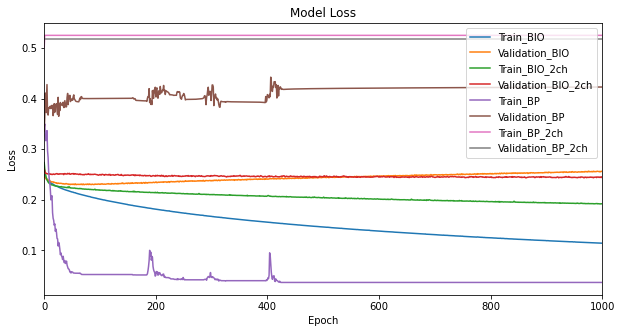

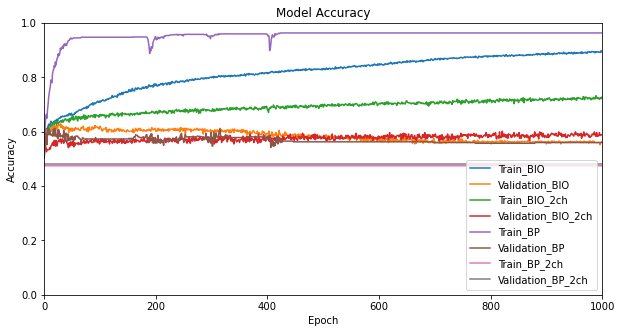

In [622]:
bio_history = bio_logs.history
bp_history = bp_logs.history
bio_history_2ch = bio_logs_2ch.history
bp_history_2ch = bp_logs_2ch.history

plt.figure(figsize=(10, 5))
plt.plot(bio_history['loss'])
plt.plot(bio_history['val_loss'])
plt.plot(bio_history_2ch['loss'])
plt.plot(bio_history_2ch['val_loss'])

plt.plot(bp_history['loss'])
plt.plot(bp_history['val_loss'])
plt.plot(bp_history_2ch['loss'])
plt.plot(bp_history_2ch['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, 1000)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BIO_2ch', 'Validation_BIO_2ch', 'Train_BP', 'Validation_BP', 
            'Train_BP_2ch', 'Validation_BP_2ch'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(bio_history['acc'])
plt.plot(bio_history['val_acc'])
plt.plot(bio_history_2ch['acc'])
plt.plot(bio_history_2ch['val_acc'])

plt.plot(bp_history['acc'])
plt.plot(bp_history['val_acc'])
plt.plot(bp_history_2ch['acc'])
plt.plot(bp_history_2ch['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.xlim(0, 1000)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BIO_2ch', 'Validation_BIO_2ch', 'Train_BP', 'Validation_BP', 
            'Train_BP_2ch', 'Validation_BP_2ch'], loc='lower right')
plt.show()

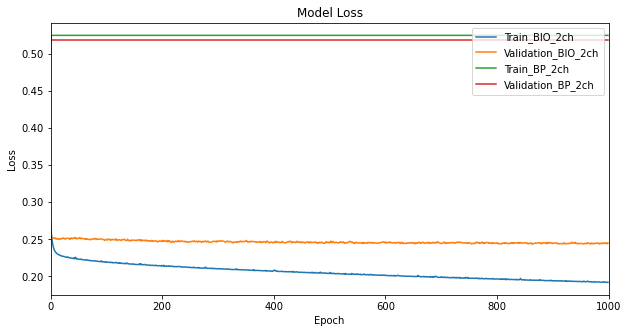

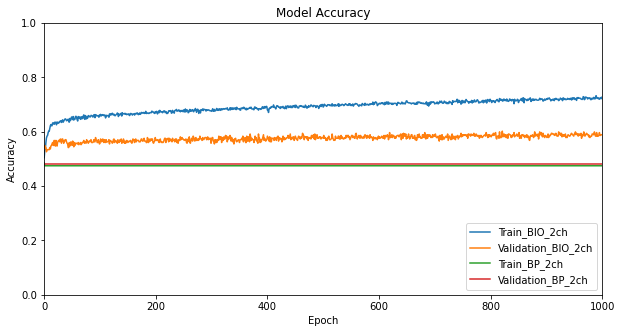

In [623]:
bio_history_2ch = bio_logs_2ch.history
bp_history_2ch = bp_logs_2ch.history

plt.figure(figsize=(10, 5))
plt.plot(bio_history_2ch['loss'])
plt.plot(bio_history_2ch['val_loss'])

plt.plot(bp_history_2ch['loss'])
plt.plot(bp_history_2ch['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, 1000)
plt.legend(['Train_BIO_2ch', 'Validation_BIO_2ch', 'Train_BP_2ch', 'Validation_BP_2ch'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(bio_history_2ch['acc'])
plt.plot(bio_history_2ch['val_acc'])

plt.plot(bp_history_2ch['acc'])
plt.plot(bp_history_2ch['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.xlim(0, 1000)
plt.legend(['Train_BIO_2ch', 'Validation_BIO_2ch', 'Train_BP_2ch', 'Validation_BP_2ch'], loc='lower right')
plt.show()

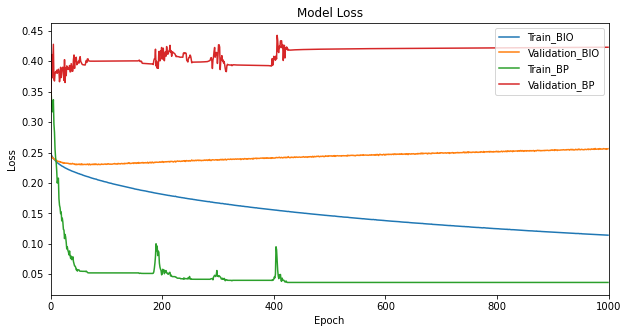

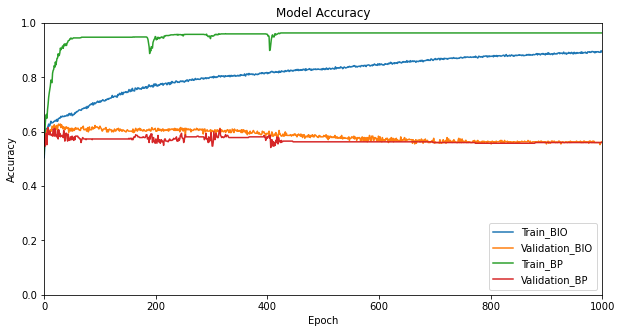

In [624]:
bio_history = bio_logs.history
bp_history = bp_logs.history

plt.figure(figsize=(10, 5))
plt.plot(bio_history['loss'])
plt.plot(bio_history['val_loss'])

plt.plot(bp_history['loss'])
plt.plot(bp_history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, 1000)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(bio_history['acc'])
plt.plot(bio_history['val_acc'])

plt.plot(bp_history['acc'])
plt.plot(bp_history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.xlim(0, 1000)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='lower right')
plt.show()

## Plot weights of the BP model

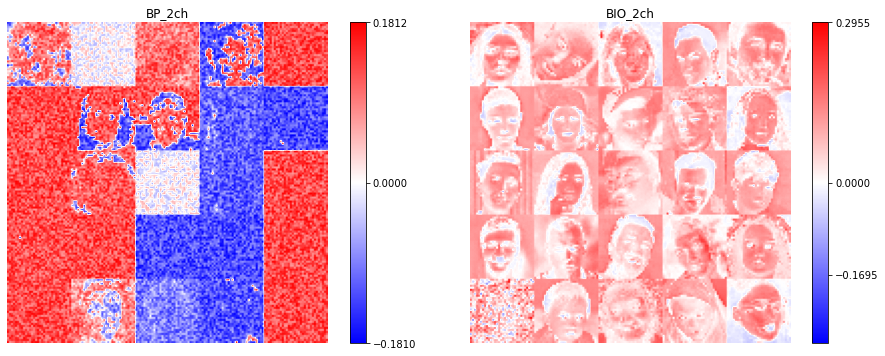

In [625]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].set_title('BP_2ch')
ax[1].set_title('BIO_2ch')
bp_weights_2ch = bp_model_2ch.layers[0].get_weights()[0].T
draw_weights_2ch(bp_weights_2ch, Kx, Ky, -1, ax[0])
draw_weights_2ch(synapses_2ch, Kx, Ky, -1, ax[1])
plt.tight_layout()
plt.show()

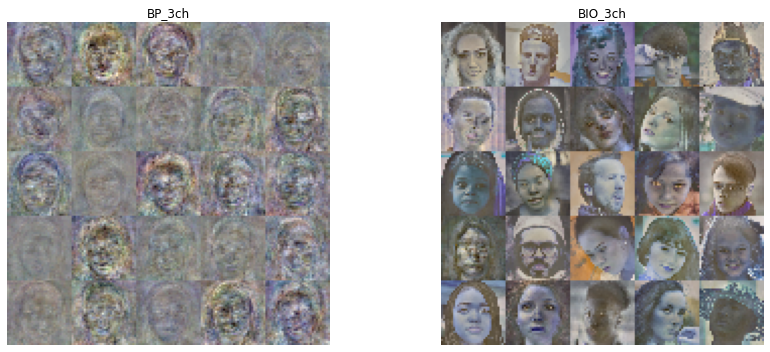

In [626]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].set_title('BP_3ch')
ax[1].set_title('BIO_3ch')
bp_weights = bp_model.layers[0].get_weights()[0].T
draw_weights(bp_weights, Kx, Ky, -1, ax[0])
draw_weights(synapses, Kx, Ky, -1, ax[1])
plt.tight_layout()
plt.show()

### Control Test: A model with only one output layer
If a model with only one output layer performs on paar with BIO, this means the images themselves are as representative as the biological hidden neurons.

In [627]:
control_model = keras.Sequential([
    layers.Input(shape=(N_in_2ch)),
    layers.BatchNormalization(),
    layers.Dense(Nc, activation='softmax')
])
control_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
control_logs = control_model.fit(x_train0_2ch, y_train_2ch, validation_data=(x_val0_2ch, y_val_2ch), batch_size=100, 
                                 epochs=100, verbose=0)

In [628]:
print("Final Training Accuracy 2ch:", control_logs.history['acc'][-1])
print("Final Validation Accuracy 2ch:", control_logs.history['val_acc'][-1])

Final Training Accuracy 2ch: 0.8728223
Final Validation Accuracy 2ch: 0.5471204


In [629]:
control_model = keras.Sequential([
    layers.Input(shape=(N_in)),
    layers.BatchNormalization(),
    layers.Dense(Nc, activation='softmax')
])
control_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
control_logs = control_model.fit(x_train0, y_train, validation_data=(x_val0, y_val), batch_size=100, epochs=100, verbose=0)

In [630]:
print("Final Training Accuracy:", control_logs.history['acc'][-1])
print("Final Validation Accuracy:", control_logs.history['val_acc'][-1])

Final Training Accuracy: 0.76829267
Final Validation Accuracy: 0.58115184


## Define CNN-BIO model

In [645]:
bio_cnn_model = models.Sequential()
bio_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(10, 10, 10)))
bio_cnn_model.add(layers.MaxPooling2D((2, 2)))
bio_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
bio_cnn_model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
bio_cnn_model.add(layers.Flatten())
bio_cnn_model.add(layers.Dense(64, activation='softmax'))
bio_cnn_model.add(layers.Dense(2))
bio_cnn_model.summary()

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 8, 8, 32)          2912      
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_47 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_152 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_153 (Dense)            (None, 2)               

In [646]:
x_hid_train3 = x_hid_train.reshape(x_hid_train.shape[0], 10, 10, 10)
x_hid_val3 = x_hid_val.reshape(x_hid_val.shape[0], 10, 10, 10)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-5, decay_steps=Nep*20, decay_rate=0.7, 
                                                          staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

bio_cnn_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
bio_cnn_model_history = bio_cnn_model.fit(x_hid_train3, y_train_one, batch_size=10, epochs=1000, 
                                          validation_data=(x_hid_val3, y_val_one))

Train on 1148 samples, validate on 382 samples
Epoch 1/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6931 - acc: 0.5131 - val_loss: 0.6927 - val_acc: 0.5550
Epoch 2/1000
1148/1148 [==============================] - 1s 585us/sample - loss: 0.6930 - acc: 0.5131 - val_loss: 0.6927 - val_acc: 0.5550
Epoch 3/1000
1148/1148 [==============================] - 1s 601us/sample - loss: 0.6930 - acc: 0.5131 - val_loss: 0.6927 - val_acc: 0.5550
Epoch 4/1000
1148/1148 [==============================] - 1s 588us/sample - loss: 0.6930 - acc: 0.5131 - val_loss: 0.6927 - val_acc: 0.5550
Epoch 5/1000
1148/1148 [==============================] - 1s 589us/sample - loss: 0.6930 - acc: 0.5131 - val_loss: 0.6926 - val_acc: 0.5550
Epoch 6/1000
1148/1148 [==============================] - 1s 586us/sample - loss: 0.6930 - acc: 0.5131 - val_loss: 0.6926 - val_acc: 0.5550
Epoch 7/1000
1148/1148 [==============================] - 1s 584us/sample - loss: 0.6930 - acc: 0.5131 - val_loss: 

1148/1148 [==============================] - 1s 785us/sample - loss: 0.6929 - acc: 0.5131 - val_loss: 0.6918 - val_acc: 0.5550
Epoch 60/1000
1148/1148 [==============================] - 1s 805us/sample - loss: 0.6929 - acc: 0.5131 - val_loss: 0.6918 - val_acc: 0.5550
Epoch 61/1000
1148/1148 [==============================] - 1s 803us/sample - loss: 0.6929 - acc: 0.5131 - val_loss: 0.6918 - val_acc: 0.5550
Epoch 62/1000
1148/1148 [==============================] - 1s 690us/sample - loss: 0.6929 - acc: 0.5131 - val_loss: 0.6918 - val_acc: 0.5550
Epoch 63/1000
1148/1148 [==============================] - 1s 690us/sample - loss: 0.6929 - acc: 0.5131 - val_loss: 0.6918 - val_acc: 0.5550
Epoch 64/1000
1148/1148 [==============================] - 1s 678us/sample - loss: 0.6929 - acc: 0.5131 - val_loss: 0.6918 - val_acc: 0.5550
Epoch 65/1000
1148/1148 [==============================] - 1s 694us/sample - loss: 0.6929 - acc: 0.5131 - val_loss: 0.6918 - val_acc: 0.5550
Epoch 66/1000
1148/1148 [==

Epoch 117/1000
1148/1148 [==============================] - 1s 687us/sample - loss: 0.6928 - acc: 0.5131 - val_loss: 0.6913 - val_acc: 0.5550
Epoch 118/1000
1148/1148 [==============================] - 1s 696us/sample - loss: 0.6928 - acc: 0.5131 - val_loss: 0.6913 - val_acc: 0.5550
Epoch 119/1000
1148/1148 [==============================] - 1s 657us/sample - loss: 0.6928 - acc: 0.5131 - val_loss: 0.6913 - val_acc: 0.5550
Epoch 120/1000
1148/1148 [==============================] - 1s 656us/sample - loss: 0.6928 - acc: 0.5131 - val_loss: 0.6912 - val_acc: 0.5550
Epoch 121/1000
1148/1148 [==============================] - 1s 670us/sample - loss: 0.6928 - acc: 0.5131 - val_loss: 0.6912 - val_acc: 0.5550
Epoch 122/1000
1148/1148 [==============================] - 1s 673us/sample - loss: 0.6928 - acc: 0.5131 - val_loss: 0.6912 - val_acc: 0.5550
Epoch 123/1000
1148/1148 [==============================] - 1s 686us/sample - loss: 0.6928 - acc: 0.5131 - val_loss: 0.6912 - val_acc: 0.5550
Epoch 

Epoch 175/1000
1148/1148 [==============================] - 1s 648us/sample - loss: 0.6927 - acc: 0.5131 - val_loss: 0.6909 - val_acc: 0.5550
Epoch 176/1000
1148/1148 [==============================] - 1s 651us/sample - loss: 0.6927 - acc: 0.5131 - val_loss: 0.6909 - val_acc: 0.5550
Epoch 177/1000
1148/1148 [==============================] - 1s 649us/sample - loss: 0.6927 - acc: 0.5131 - val_loss: 0.6909 - val_acc: 0.5550
Epoch 178/1000
1148/1148 [==============================] - 1s 657us/sample - loss: 0.6927 - acc: 0.5131 - val_loss: 0.6909 - val_acc: 0.5550
Epoch 179/1000
1148/1148 [==============================] - 1s 647us/sample - loss: 0.6927 - acc: 0.5131 - val_loss: 0.6909 - val_acc: 0.5550
Epoch 180/1000
1148/1148 [==============================] - 1s 644us/sample - loss: 0.6927 - acc: 0.5131 - val_loss: 0.6909 - val_acc: 0.5550
Epoch 181/1000
1148/1148 [==============================] - 1s 674us/sample - loss: 0.6927 - acc: 0.5131 - val_loss: 0.6909 - val_acc: 0.5550
Epoch 

Epoch 233/1000
1148/1148 [==============================] - 1s 650us/sample - loss: 0.6926 - acc: 0.5131 - val_loss: 0.6907 - val_acc: 0.5550
Epoch 234/1000
1148/1148 [==============================] - 1s 663us/sample - loss: 0.6926 - acc: 0.5131 - val_loss: 0.6907 - val_acc: 0.5550
Epoch 235/1000
1148/1148 [==============================] - 1s 659us/sample - loss: 0.6926 - acc: 0.5131 - val_loss: 0.6907 - val_acc: 0.5550
Epoch 236/1000
1148/1148 [==============================] - 1s 665us/sample - loss: 0.6926 - acc: 0.5131 - val_loss: 0.6907 - val_acc: 0.5550
Epoch 237/1000
1148/1148 [==============================] - 1s 652us/sample - loss: 0.6926 - acc: 0.5131 - val_loss: 0.6907 - val_acc: 0.5550
Epoch 238/1000
1148/1148 [==============================] - 1s 680us/sample - loss: 0.6926 - acc: 0.5131 - val_loss: 0.6907 - val_acc: 0.5550
Epoch 239/1000
1148/1148 [==============================] - 1s 653us/sample - loss: 0.6926 - acc: 0.5131 - val_loss: 0.6907 - val_acc: 0.5550
Epoch 

Epoch 291/1000
1148/1148 [==============================] - 1s 684us/sample - loss: 0.6924 - acc: 0.5131 - val_loss: 0.6905 - val_acc: 0.5550
Epoch 292/1000
1148/1148 [==============================] - 1s 667us/sample - loss: 0.6924 - acc: 0.5131 - val_loss: 0.6905 - val_acc: 0.5550
Epoch 293/1000
1148/1148 [==============================] - 1s 690us/sample - loss: 0.6924 - acc: 0.5131 - val_loss: 0.6905 - val_acc: 0.5550
Epoch 294/1000
1148/1148 [==============================] - 1s 686us/sample - loss: 0.6924 - acc: 0.5131 - val_loss: 0.6905 - val_acc: 0.5550
Epoch 295/1000
1148/1148 [==============================] - 1s 654us/sample - loss: 0.6924 - acc: 0.5131 - val_loss: 0.6905 - val_acc: 0.5550
Epoch 296/1000
1148/1148 [==============================] - 1s 687us/sample - loss: 0.6924 - acc: 0.5131 - val_loss: 0.6905 - val_acc: 0.5550
Epoch 297/1000
1148/1148 [==============================] - 1s 659us/sample - loss: 0.6924 - acc: 0.5131 - val_loss: 0.6905 - val_acc: 0.5550
Epoch 

Epoch 349/1000
1148/1148 [==============================] - 1s 650us/sample - loss: 0.6922 - acc: 0.5131 - val_loss: 0.6904 - val_acc: 0.5550
Epoch 350/1000
1148/1148 [==============================] - 1s 676us/sample - loss: 0.6922 - acc: 0.5131 - val_loss: 0.6904 - val_acc: 0.5550
Epoch 351/1000
1148/1148 [==============================] - 1s 650us/sample - loss: 0.6922 - acc: 0.5131 - val_loss: 0.6904 - val_acc: 0.5550
Epoch 352/1000
1148/1148 [==============================] - 1s 653us/sample - loss: 0.6922 - acc: 0.5131 - val_loss: 0.6904 - val_acc: 0.5550
Epoch 353/1000
1148/1148 [==============================] - 1s 671us/sample - loss: 0.6922 - acc: 0.5131 - val_loss: 0.6904 - val_acc: 0.5550
Epoch 354/1000
1148/1148 [==============================] - 1s 650us/sample - loss: 0.6922 - acc: 0.5131 - val_loss: 0.6904 - val_acc: 0.5550
Epoch 355/1000
1148/1148 [==============================] - 1s 661us/sample - loss: 0.6922 - acc: 0.5131 - val_loss: 0.6904 - val_acc: 0.5550
Epoch 

Epoch 407/1000
1148/1148 [==============================] - 1s 684us/sample - loss: 0.6920 - acc: 0.5131 - val_loss: 0.6903 - val_acc: 0.5550
Epoch 408/1000
1148/1148 [==============================] - 1s 673us/sample - loss: 0.6920 - acc: 0.5131 - val_loss: 0.6903 - val_acc: 0.5550
Epoch 409/1000
1148/1148 [==============================] - 1s 682us/sample - loss: 0.6920 - acc: 0.5131 - val_loss: 0.6903 - val_acc: 0.5550
Epoch 410/1000
1148/1148 [==============================] - 1s 663us/sample - loss: 0.6920 - acc: 0.5131 - val_loss: 0.6903 - val_acc: 0.5550
Epoch 411/1000
1148/1148 [==============================] - 1s 680us/sample - loss: 0.6920 - acc: 0.5131 - val_loss: 0.6903 - val_acc: 0.5550
Epoch 412/1000
1148/1148 [==============================] - 1s 695us/sample - loss: 0.6920 - acc: 0.5131 - val_loss: 0.6903 - val_acc: 0.5550
Epoch 413/1000
1148/1148 [==============================] - 1s 678us/sample - loss: 0.6920 - acc: 0.5131 - val_loss: 0.6903 - val_acc: 0.5550
Epoch 

Epoch 465/1000
1148/1148 [==============================] - 1s 687us/sample - loss: 0.6917 - acc: 0.5131 - val_loss: 0.6902 - val_acc: 0.5550
Epoch 466/1000
1148/1148 [==============================] - 1s 661us/sample - loss: 0.6917 - acc: 0.5131 - val_loss: 0.6902 - val_acc: 0.5550
Epoch 467/1000
1148/1148 [==============================] - 1s 660us/sample - loss: 0.6917 - acc: 0.5131 - val_loss: 0.6902 - val_acc: 0.5550
Epoch 468/1000
1148/1148 [==============================] - 1s 665us/sample - loss: 0.6917 - acc: 0.5131 - val_loss: 0.6902 - val_acc: 0.5550
Epoch 469/1000
1148/1148 [==============================] - 1s 723us/sample - loss: 0.6917 - acc: 0.5131 - val_loss: 0.6902 - val_acc: 0.5550
Epoch 470/1000
1148/1148 [==============================] - 1s 693us/sample - loss: 0.6917 - acc: 0.5131 - val_loss: 0.6902 - val_acc: 0.5550
Epoch 471/1000
1148/1148 [==============================] - 1s 720us/sample - loss: 0.6917 - acc: 0.5131 - val_loss: 0.6902 - val_acc: 0.5550
Epoch 

Epoch 523/1000
1148/1148 [==============================] - 1s 669us/sample - loss: 0.6914 - acc: 0.5131 - val_loss: 0.6901 - val_acc: 0.5550
Epoch 524/1000
1148/1148 [==============================] - 1s 667us/sample - loss: 0.6914 - acc: 0.5131 - val_loss: 0.6901 - val_acc: 0.5550
Epoch 525/1000
1148/1148 [==============================] - 1s 686us/sample - loss: 0.6914 - acc: 0.5131 - val_loss: 0.6900 - val_acc: 0.5550
Epoch 526/1000
1148/1148 [==============================] - 1s 661us/sample - loss: 0.6914 - acc: 0.5131 - val_loss: 0.6901 - val_acc: 0.5550
Epoch 527/1000
1148/1148 [==============================] - 1s 676us/sample - loss: 0.6914 - acc: 0.5131 - val_loss: 0.6900 - val_acc: 0.5550
Epoch 528/1000
1148/1148 [==============================] - 1s 658us/sample - loss: 0.6914 - acc: 0.5131 - val_loss: 0.6900 - val_acc: 0.5550
Epoch 529/1000
1148/1148 [==============================] - 1s 702us/sample - loss: 0.6914 - acc: 0.5131 - val_loss: 0.6900 - val_acc: 0.5550
Epoch 

Epoch 581/1000
1148/1148 [==============================] - 1s 666us/sample - loss: 0.6910 - acc: 0.5131 - val_loss: 0.6899 - val_acc: 0.5550
Epoch 582/1000
1148/1148 [==============================] - 1s 659us/sample - loss: 0.6910 - acc: 0.5131 - val_loss: 0.6899 - val_acc: 0.5550
Epoch 583/1000
1148/1148 [==============================] - 1s 664us/sample - loss: 0.6910 - acc: 0.5131 - val_loss: 0.6899 - val_acc: 0.5550
Epoch 584/1000
1148/1148 [==============================] - 1s 687us/sample - loss: 0.6910 - acc: 0.5131 - val_loss: 0.6899 - val_acc: 0.5550
Epoch 585/1000
1148/1148 [==============================] - 1s 658us/sample - loss: 0.6910 - acc: 0.5131 - val_loss: 0.6899 - val_acc: 0.5550
Epoch 586/1000
1148/1148 [==============================] - 1s 689us/sample - loss: 0.6910 - acc: 0.5131 - val_loss: 0.6899 - val_acc: 0.5550
Epoch 587/1000
1148/1148 [==============================] - 1s 658us/sample - loss: 0.6910 - acc: 0.5131 - val_loss: 0.6899 - val_acc: 0.5550
Epoch 

Epoch 639/1000
1148/1148 [==============================] - 1s 718us/sample - loss: 0.6905 - acc: 0.5131 - val_loss: 0.6897 - val_acc: 0.5550
Epoch 640/1000
1148/1148 [==============================] - 1s 716us/sample - loss: 0.6905 - acc: 0.5131 - val_loss: 0.6897 - val_acc: 0.5550
Epoch 641/1000
1148/1148 [==============================] - 1s 742us/sample - loss: 0.6905 - acc: 0.5131 - val_loss: 0.6897 - val_acc: 0.5550
Epoch 642/1000
1148/1148 [==============================] - 1s 727us/sample - loss: 0.6905 - acc: 0.5131 - val_loss: 0.6897 - val_acc: 0.5550
Epoch 643/1000
1148/1148 [==============================] - 1s 684us/sample - loss: 0.6905 - acc: 0.5131 - val_loss: 0.6897 - val_acc: 0.5550
Epoch 644/1000
1148/1148 [==============================] - 1s 701us/sample - loss: 0.6905 - acc: 0.5131 - val_loss: 0.6897 - val_acc: 0.5550
Epoch 645/1000
1148/1148 [==============================] - 1s 677us/sample - loss: 0.6905 - acc: 0.5131 - val_loss: 0.6897 - val_acc: 0.5550
Epoch 

Epoch 697/1000
1148/1148 [==============================] - 1s 676us/sample - loss: 0.6899 - acc: 0.5148 - val_loss: 0.6894 - val_acc: 0.5550
Epoch 698/1000
1148/1148 [==============================] - 1s 766us/sample - loss: 0.6899 - acc: 0.5148 - val_loss: 0.6894 - val_acc: 0.5550
Epoch 699/1000
1148/1148 [==============================] - 1s 678us/sample - loss: 0.6899 - acc: 0.5148 - val_loss: 0.6894 - val_acc: 0.5550
Epoch 700/1000
1148/1148 [==============================] - 1s 669us/sample - loss: 0.6899 - acc: 0.5148 - val_loss: 0.6894 - val_acc: 0.5550
Epoch 701/1000
1148/1148 [==============================] - 1s 653us/sample - loss: 0.6899 - acc: 0.5148 - val_loss: 0.6895 - val_acc: 0.5550
Epoch 702/1000
1148/1148 [==============================] - 1s 677us/sample - loss: 0.6899 - acc: 0.5148 - val_loss: 0.6895 - val_acc: 0.5550
Epoch 703/1000
1148/1148 [==============================] - 1s 661us/sample - loss: 0.6899 - acc: 0.5148 - val_loss: 0.6894 - val_acc: 0.5550
Epoch 

Epoch 755/1000
1148/1148 [==============================] - 1s 601us/sample - loss: 0.6895 - acc: 0.5200 - val_loss: 0.6893 - val_acc: 0.5550
Epoch 756/1000
1148/1148 [==============================] - 1s 622us/sample - loss: 0.6895 - acc: 0.5209 - val_loss: 0.6893 - val_acc: 0.5550
Epoch 757/1000
1148/1148 [==============================] - 1s 692us/sample - loss: 0.6895 - acc: 0.5200 - val_loss: 0.6893 - val_acc: 0.5550
Epoch 758/1000
1148/1148 [==============================] - 1s 726us/sample - loss: 0.6894 - acc: 0.5200 - val_loss: 0.6893 - val_acc: 0.5550
Epoch 759/1000
1148/1148 [==============================] - 1s 734us/sample - loss: 0.6894 - acc: 0.5209 - val_loss: 0.6893 - val_acc: 0.5550
Epoch 760/1000
1148/1148 [==============================] - 1s 743us/sample - loss: 0.6894 - acc: 0.5209 - val_loss: 0.6892 - val_acc: 0.5550
Epoch 761/1000
1148/1148 [==============================] - 1s 702us/sample - loss: 0.6894 - acc: 0.5209 - val_loss: 0.6892 - val_acc: 0.5550
Epoch 

1148/1148 [==============================] - 1s 1ms/sample - loss: 0.6889 - acc: 0.5270 - val_loss: 0.6891 - val_acc: 0.5550
Epoch 813/1000
1148/1148 [==============================] - 1s 1ms/sample - loss: 0.6889 - acc: 0.5279 - val_loss: 0.6891 - val_acc: 0.5550
Epoch 814/1000
1148/1148 [==============================] - 1s 996us/sample - loss: 0.6889 - acc: 0.5279 - val_loss: 0.6890 - val_acc: 0.5550
Epoch 815/1000
1148/1148 [==============================] - 1s 895us/sample - loss: 0.6889 - acc: 0.5270 - val_loss: 0.6890 - val_acc: 0.5550
Epoch 816/1000
1148/1148 [==============================] - 1s 882us/sample - loss: 0.6889 - acc: 0.5296 - val_loss: 0.6891 - val_acc: 0.5550
Epoch 817/1000
1148/1148 [==============================] - 1s 955us/sample - loss: 0.6889 - acc: 0.5287 - val_loss: 0.6891 - val_acc: 0.5550
Epoch 818/1000
1148/1148 [==============================] - 1s 910us/sample - loss: 0.6889 - acc: 0.5296 - val_loss: 0.6891 - val_acc: 0.5550
Epoch 819/1000
1148/1148 

1148/1148 [==============================] - 1s 889us/sample - loss: 0.6883 - acc: 0.5383 - val_loss: 0.6888 - val_acc: 0.5524
Epoch 871/1000
1148/1148 [==============================] - 1s 891us/sample - loss: 0.6883 - acc: 0.5348 - val_loss: 0.6888 - val_acc: 0.5524
Epoch 872/1000
1148/1148 [==============================] - 1s 878us/sample - loss: 0.6883 - acc: 0.5375 - val_loss: 0.6888 - val_acc: 0.5550
Epoch 873/1000
1148/1148 [==============================] - 1s 879us/sample - loss: 0.6883 - acc: 0.5383 - val_loss: 0.6888 - val_acc: 0.5524
Epoch 874/1000
1148/1148 [==============================] - 1s 896us/sample - loss: 0.6883 - acc: 0.5366 - val_loss: 0.6888 - val_acc: 0.5524
Epoch 875/1000
1148/1148 [==============================] - 1s 866us/sample - loss: 0.6883 - acc: 0.5366 - val_loss: 0.6888 - val_acc: 0.5524
Epoch 876/1000
1148/1148 [==============================] - 1s 881us/sample - loss: 0.6882 - acc: 0.5401 - val_loss: 0.6888 - val_acc: 0.5524
Epoch 877/1000
1148/1

Epoch 928/1000
1148/1148 [==============================] - 1s 906us/sample - loss: 0.6876 - acc: 0.5505 - val_loss: 0.6885 - val_acc: 0.5654
Epoch 929/1000
1148/1148 [==============================] - 1s 870us/sample - loss: 0.6876 - acc: 0.5427 - val_loss: 0.6885 - val_acc: 0.5628
Epoch 930/1000
1148/1148 [==============================] - 1s 905us/sample - loss: 0.6876 - acc: 0.5444 - val_loss: 0.6885 - val_acc: 0.5628
Epoch 931/1000
1148/1148 [==============================] - 1s 866us/sample - loss: 0.6876 - acc: 0.5462 - val_loss: 0.6885 - val_acc: 0.5654
Epoch 932/1000
1148/1148 [==============================] - 1s 853us/sample - loss: 0.6876 - acc: 0.5462 - val_loss: 0.6885 - val_acc: 0.5654
Epoch 933/1000
1148/1148 [==============================] - 1s 865us/sample - loss: 0.6876 - acc: 0.5488 - val_loss: 0.6885 - val_acc: 0.5654
Epoch 934/1000
1148/1148 [==============================] - 1s 877us/sample - loss: 0.6875 - acc: 0.5444 - val_loss: 0.6885 - val_acc: 0.5654
Epoch 

Epoch 986/1000
1148/1148 [==============================] - 1s 886us/sample - loss: 0.6868 - acc: 0.5566 - val_loss: 0.6882 - val_acc: 0.5707
Epoch 987/1000
1148/1148 [==============================] - 1s 905us/sample - loss: 0.6868 - acc: 0.5584 - val_loss: 0.6882 - val_acc: 0.5733
Epoch 988/1000
1148/1148 [==============================] - 1s 930us/sample - loss: 0.6868 - acc: 0.5610 - val_loss: 0.6882 - val_acc: 0.5759
Epoch 989/1000
1148/1148 [==============================] - 1s 1ms/sample - loss: 0.6868 - acc: 0.5592 - val_loss: 0.6882 - val_acc: 0.5733
Epoch 990/1000
1148/1148 [==============================] - 1s 978us/sample - loss: 0.6868 - acc: 0.5601 - val_loss: 0.6881 - val_acc: 0.5733
Epoch 991/1000
1148/1148 [==============================] - 1s 940us/sample - loss: 0.6867 - acc: 0.5557 - val_loss: 0.6881 - val_acc: 0.5707
Epoch 992/1000
1148/1148 [==============================] - 1s 904us/sample - loss: 0.6867 - acc: 0.5592 - val_loss: 0.6881 - val_acc: 0.5733
Epoch 99

In [647]:
x_hid_test3 = x_hid_test.reshape(x_hid_test.shape[0], 10, 10, 10)
bio_cnn_model.evaluate(x_hid_test3, y_test_one)

511/511 [==============================] - 0s 365us/sample - loss: 0.6885 - acc: 0.5225


[0.6885040850322074, 0.52250487]

In [648]:
bio_cnn_model_2ch = models.Sequential()
bio_cnn_model_2ch.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(10, 10, 10)))
bio_cnn_model_2ch.add(layers.MaxPooling2D((2, 2)))
bio_cnn_model_2ch.add(layers.Conv2D(64, (3, 3), activation='relu'))
bio_cnn_model_2ch.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
bio_cnn_model_2ch.add(layers.Flatten())
bio_cnn_model_2ch.add(layers.Dense(64, activation='softmax'))
bio_cnn_model_2ch.add(layers.Dense(2))
bio_cnn_model_2ch.summary()

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_123 (Conv2D)          (None, 8, 8, 32)          2912      
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_48 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_154 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_155 (Dense)            (None, 2)               

In [649]:
x_hid_train_2ch_cnn = x_hid_train_2ch.reshape(x_hid_train_2ch.shape[0], 10, 10, 10)
x_hid_val_2ch_cnn = x_hid_val_2ch.reshape(x_hid_val_2ch.shape[0], 10, 10, 10)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-5, decay_steps=Nep*20, decay_rate=0.7, 
                                                          staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

bio_cnn_model_2ch.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                          metrics=['accuracy'])
bio_cnn_model_2ch_history = bio_cnn_model_2ch.fit(x_hid_train_2ch_cnn, y_train_2ch_one, batch_size=100, epochs=1000, 
                                          validation_data=(x_hid_val_2ch_cnn, y_val_2ch_one))

Train on 1148 samples, validate on 382 samples
Epoch 1/1000
1148/1148 [==============================] - 3s 3ms/sample - loss: 0.6948 - acc: 0.4747 - val_loss: 0.6940 - val_acc: 0.4817
Epoch 2/1000
1148/1148 [==============================] - 0s 198us/sample - loss: 0.6947 - acc: 0.4747 - val_loss: 0.6940 - val_acc: 0.4817
Epoch 3/1000
1148/1148 [==============================] - 0s 220us/sample - loss: 0.6946 - acc: 0.4747 - val_loss: 0.6939 - val_acc: 0.4817
Epoch 4/1000
1148/1148 [==============================] - 0s 246us/sample - loss: 0.6946 - acc: 0.4747 - val_loss: 0.6939 - val_acc: 0.4817
Epoch 5/1000
1148/1148 [==============================] - 0s 213us/sample - loss: 0.6945 - acc: 0.4747 - val_loss: 0.6938 - val_acc: 0.4817
Epoch 6/1000
1148/1148 [==============================] - 0s 204us/sample - loss: 0.6944 - acc: 0.4747 - val_loss: 0.6938 - val_acc: 0.4817
Epoch 7/1000
1148/1148 [==============================] - 0s 203us/sample - loss: 0.6944 - acc: 0.4747 - val_loss: 

Epoch 59/1000
1148/1148 [==============================] - 0s 256us/sample - loss: 0.6914 - acc: 0.5253 - val_loss: 0.6922 - val_acc: 0.5183
Epoch 60/1000
1148/1148 [==============================] - 0s 214us/sample - loss: 0.6913 - acc: 0.5253 - val_loss: 0.6922 - val_acc: 0.5183
Epoch 61/1000
1148/1148 [==============================] - 0s 193us/sample - loss: 0.6912 - acc: 0.5253 - val_loss: 0.6922 - val_acc: 0.5183
Epoch 62/1000
1148/1148 [==============================] - 0s 190us/sample - loss: 0.6912 - acc: 0.5253 - val_loss: 0.6922 - val_acc: 0.5183
Epoch 63/1000
1148/1148 [==============================] - 0s 226us/sample - loss: 0.6911 - acc: 0.5253 - val_loss: 0.6921 - val_acc: 0.5183
Epoch 64/1000
1148/1148 [==============================] - 0s 240us/sample - loss: 0.6910 - acc: 0.5253 - val_loss: 0.6921 - val_acc: 0.5183
Epoch 65/1000
1148/1148 [==============================] - 0s 193us/sample - loss: 0.6910 - acc: 0.5253 - val_loss: 0.6921 - val_acc: 0.5183
Epoch 66/1000

Epoch 117/1000
1148/1148 [==============================] - 0s 194us/sample - loss: 0.6876 - acc: 0.5253 - val_loss: 0.6917 - val_acc: 0.5183
Epoch 118/1000
1148/1148 [==============================] - 0s 189us/sample - loss: 0.6875 - acc: 0.5253 - val_loss: 0.6917 - val_acc: 0.5183
Epoch 119/1000
1148/1148 [==============================] - 0s 257us/sample - loss: 0.6874 - acc: 0.5253 - val_loss: 0.6917 - val_acc: 0.5183
Epoch 120/1000
1148/1148 [==============================] - 0s 199us/sample - loss: 0.6874 - acc: 0.5253 - val_loss: 0.6917 - val_acc: 0.5183
Epoch 121/1000
1148/1148 [==============================] - 0s 191us/sample - loss: 0.6873 - acc: 0.5253 - val_loss: 0.6917 - val_acc: 0.5183
Epoch 122/1000
1148/1148 [==============================] - 0s 182us/sample - loss: 0.6872 - acc: 0.5253 - val_loss: 0.6917 - val_acc: 0.5183
Epoch 123/1000
1148/1148 [==============================] - 0s 269us/sample - loss: 0.6872 - acc: 0.5253 - val_loss: 0.6918 - val_acc: 0.5183
Epoch 

Epoch 175/1000
1148/1148 [==============================] - 0s 275us/sample - loss: 0.6840 - acc: 0.5270 - val_loss: 0.6923 - val_acc: 0.5183
Epoch 176/1000
1148/1148 [==============================] - 0s 220us/sample - loss: 0.6839 - acc: 0.5270 - val_loss: 0.6923 - val_acc: 0.5183
Epoch 177/1000
1148/1148 [==============================] - 0s 215us/sample - loss: 0.6839 - acc: 0.5270 - val_loss: 0.6923 - val_acc: 0.5183
Epoch 178/1000
1148/1148 [==============================] - 0s 220us/sample - loss: 0.6838 - acc: 0.5270 - val_loss: 0.6924 - val_acc: 0.5183
Epoch 179/1000
1148/1148 [==============================] - 0s 287us/sample - loss: 0.6837 - acc: 0.5270 - val_loss: 0.6924 - val_acc: 0.5183
Epoch 180/1000
1148/1148 [==============================] - 0s 217us/sample - loss: 0.6837 - acc: 0.5279 - val_loss: 0.6924 - val_acc: 0.5183
Epoch 181/1000
1148/1148 [==============================] - 0s 206us/sample - loss: 0.6836 - acc: 0.5279 - val_loss: 0.6924 - val_acc: 0.5183
Epoch 

Epoch 233/1000
1148/1148 [==============================] - 0s 192us/sample - loss: 0.6803 - acc: 0.5575 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 234/1000
1148/1148 [==============================] - 0s 185us/sample - loss: 0.6802 - acc: 0.5592 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 235/1000
1148/1148 [==============================] - 0s 265us/sample - loss: 0.6802 - acc: 0.5592 - val_loss: 0.6931 - val_acc: 0.5052
Epoch 236/1000
1148/1148 [==============================] - 0s 198us/sample - loss: 0.6801 - acc: 0.5627 - val_loss: 0.6931 - val_acc: 0.5079
Epoch 237/1000
1148/1148 [==============================] - 0s 191us/sample - loss: 0.6800 - acc: 0.5645 - val_loss: 0.6931 - val_acc: 0.5052
Epoch 238/1000
1148/1148 [==============================] - 0s 186us/sample - loss: 0.6800 - acc: 0.5636 - val_loss: 0.6931 - val_acc: 0.5052
Epoch 239/1000
1148/1148 [==============================] - 0s 264us/sample - loss: 0.6799 - acc: 0.5618 - val_loss: 0.6931 - val_acc: 0.5079
Epoch 

Epoch 291/1000
1148/1148 [==============================] - 0s 231us/sample - loss: 0.6763 - acc: 0.5862 - val_loss: 0.6937 - val_acc: 0.4817
Epoch 292/1000
1148/1148 [==============================] - 0s 200us/sample - loss: 0.6762 - acc: 0.5871 - val_loss: 0.6937 - val_acc: 0.4817
Epoch 293/1000
1148/1148 [==============================] - 0s 191us/sample - loss: 0.6761 - acc: 0.5880 - val_loss: 0.6937 - val_acc: 0.4817
Epoch 294/1000
1148/1148 [==============================] - 0s 214us/sample - loss: 0.6761 - acc: 0.5897 - val_loss: 0.6937 - val_acc: 0.4791
Epoch 295/1000
1148/1148 [==============================] - 0s 242us/sample - loss: 0.6760 - acc: 0.5897 - val_loss: 0.6937 - val_acc: 0.4817
Epoch 296/1000
1148/1148 [==============================] - 0s 197us/sample - loss: 0.6759 - acc: 0.5906 - val_loss: 0.6937 - val_acc: 0.4791
Epoch 297/1000
1148/1148 [==============================] - 0s 191us/sample - loss: 0.6758 - acc: 0.5906 - val_loss: 0.6937 - val_acc: 0.4660
Epoch 

Epoch 349/1000
1148/1148 [==============================] - 0s 192us/sample - loss: 0.6720 - acc: 0.6150 - val_loss: 0.6939 - val_acc: 0.4843
Epoch 350/1000
1148/1148 [==============================] - 0s 245us/sample - loss: 0.6720 - acc: 0.6159 - val_loss: 0.6939 - val_acc: 0.4869
Epoch 351/1000
1148/1148 [==============================] - 0s 221us/sample - loss: 0.6719 - acc: 0.6159 - val_loss: 0.6939 - val_acc: 0.4869
Epoch 352/1000
1148/1148 [==============================] - 0s 196us/sample - loss: 0.6718 - acc: 0.6150 - val_loss: 0.6939 - val_acc: 0.4817
Epoch 353/1000
1148/1148 [==============================] - 0s 210us/sample - loss: 0.6717 - acc: 0.6167 - val_loss: 0.6940 - val_acc: 0.4843
Epoch 354/1000
1148/1148 [==============================] - 0s 217us/sample - loss: 0.6717 - acc: 0.6176 - val_loss: 0.6939 - val_acc: 0.4843
Epoch 355/1000
1148/1148 [==============================] - 0s 242us/sample - loss: 0.6716 - acc: 0.6185 - val_loss: 0.6939 - val_acc: 0.4843
Epoch 

Epoch 407/1000
1148/1148 [==============================] - 0s 198us/sample - loss: 0.6678 - acc: 0.6228 - val_loss: 0.6940 - val_acc: 0.4948
Epoch 408/1000
1148/1148 [==============================] - 0s 196us/sample - loss: 0.6678 - acc: 0.6228 - val_loss: 0.6940 - val_acc: 0.4921
Epoch 409/1000
1148/1148 [==============================] - 0s 184us/sample - loss: 0.6677 - acc: 0.6237 - val_loss: 0.6940 - val_acc: 0.4921
Epoch 410/1000
1148/1148 [==============================] - 0s 256us/sample - loss: 0.6676 - acc: 0.6228 - val_loss: 0.6940 - val_acc: 0.4921
Epoch 411/1000
1148/1148 [==============================] - 0s 202us/sample - loss: 0.6675 - acc: 0.6228 - val_loss: 0.6940 - val_acc: 0.4948
Epoch 412/1000
1148/1148 [==============================] - 0s 193us/sample - loss: 0.6675 - acc: 0.6237 - val_loss: 0.6940 - val_acc: 0.4948
Epoch 413/1000
1148/1148 [==============================] - 0s 191us/sample - loss: 0.6674 - acc: 0.6254 - val_loss: 0.6940 - val_acc: 0.4948
Epoch 

Epoch 465/1000
1148/1148 [==============================] - 0s 195us/sample - loss: 0.6638 - acc: 0.6307 - val_loss: 0.6939 - val_acc: 0.4948
Epoch 466/1000
1148/1148 [==============================] - 0s 253us/sample - loss: 0.6637 - acc: 0.6307 - val_loss: 0.6939 - val_acc: 0.4948
Epoch 467/1000
1148/1148 [==============================] - 0s 198us/sample - loss: 0.6637 - acc: 0.6341 - val_loss: 0.6940 - val_acc: 0.4948
Epoch 468/1000
1148/1148 [==============================] - 0s 197us/sample - loss: 0.6636 - acc: 0.6359 - val_loss: 0.6939 - val_acc: 0.4974
Epoch 469/1000
1148/1148 [==============================] - 0s 182us/sample - loss: 0.6635 - acc: 0.6368 - val_loss: 0.6939 - val_acc: 0.4948
Epoch 470/1000
1148/1148 [==============================] - 0s 260us/sample - loss: 0.6635 - acc: 0.6368 - val_loss: 0.6939 - val_acc: 0.4974
Epoch 471/1000
1148/1148 [==============================] - 0s 206us/sample - loss: 0.6634 - acc: 0.6350 - val_loss: 0.6939 - val_acc: 0.4948
Epoch 

Epoch 523/1000
1148/1148 [==============================] - 0s 199us/sample - loss: 0.6598 - acc: 0.6559 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 524/1000
1148/1148 [==============================] - 0s 193us/sample - loss: 0.6598 - acc: 0.6577 - val_loss: 0.6939 - val_acc: 0.4921
Epoch 525/1000
1148/1148 [==============================] - 0s 185us/sample - loss: 0.6597 - acc: 0.6559 - val_loss: 0.6939 - val_acc: 0.4948
Epoch 526/1000
1148/1148 [==============================] - 0s 264us/sample - loss: 0.6596 - acc: 0.6568 - val_loss: 0.6939 - val_acc: 0.5026
Epoch 527/1000
1148/1148 [==============================] - 0s 199us/sample - loss: 0.6595 - acc: 0.6568 - val_loss: 0.6939 - val_acc: 0.5026
Epoch 528/1000
1148/1148 [==============================] - 0s 193us/sample - loss: 0.6595 - acc: 0.6577 - val_loss: 0.6939 - val_acc: 0.5026
Epoch 529/1000
1148/1148 [==============================] - 0s 187us/sample - loss: 0.6594 - acc: 0.6577 - val_loss: 0.6939 - val_acc: 0.5026
Epoch 

Epoch 581/1000
1148/1148 [==============================] - 0s 196us/sample - loss: 0.6558 - acc: 0.6646 - val_loss: 0.6938 - val_acc: 0.5026
Epoch 582/1000
1148/1148 [==============================] - 0s 254us/sample - loss: 0.6557 - acc: 0.6646 - val_loss: 0.6938 - val_acc: 0.5026
Epoch 583/1000
1148/1148 [==============================] - 0s 194us/sample - loss: 0.6557 - acc: 0.6646 - val_loss: 0.6938 - val_acc: 0.5026
Epoch 584/1000
1148/1148 [==============================] - 0s 194us/sample - loss: 0.6556 - acc: 0.6638 - val_loss: 0.6938 - val_acc: 0.5052
Epoch 585/1000
1148/1148 [==============================] - 0s 183us/sample - loss: 0.6555 - acc: 0.6664 - val_loss: 0.6938 - val_acc: 0.5052
Epoch 586/1000
1148/1148 [==============================] - 0s 271us/sample - loss: 0.6555 - acc: 0.6672 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 587/1000
1148/1148 [==============================] - 0s 198us/sample - loss: 0.6554 - acc: 0.6690 - val_loss: 0.6938 - val_acc: 0.5026
Epoch 

Epoch 639/1000
1148/1148 [==============================] - 0s 194us/sample - loss: 0.6518 - acc: 0.6751 - val_loss: 0.6938 - val_acc: 0.5105
Epoch 640/1000
1148/1148 [==============================] - 0s 197us/sample - loss: 0.6518 - acc: 0.6760 - val_loss: 0.6938 - val_acc: 0.5105
Epoch 641/1000
1148/1148 [==============================] - 0s 186us/sample - loss: 0.6517 - acc: 0.6760 - val_loss: 0.6938 - val_acc: 0.5105
Epoch 642/1000
1148/1148 [==============================] - 0s 270us/sample - loss: 0.6516 - acc: 0.6768 - val_loss: 0.6938 - val_acc: 0.5079
Epoch 643/1000
1148/1148 [==============================] - 0s 198us/sample - loss: 0.6516 - acc: 0.6751 - val_loss: 0.6938 - val_acc: 0.5079
Epoch 644/1000
1148/1148 [==============================] - 0s 195us/sample - loss: 0.6515 - acc: 0.6760 - val_loss: 0.6938 - val_acc: 0.5079
Epoch 645/1000
1148/1148 [==============================] - 0s 186us/sample - loss: 0.6514 - acc: 0.6777 - val_loss: 0.6938 - val_acc: 0.5079
Epoch 

Epoch 697/1000
1148/1148 [==============================] - 0s 240us/sample - loss: 0.6478 - acc: 0.6882 - val_loss: 0.6937 - val_acc: 0.5079
Epoch 698/1000
1148/1148 [==============================] - 0s 215us/sample - loss: 0.6477 - acc: 0.6890 - val_loss: 0.6937 - val_acc: 0.5157
Epoch 699/1000
1148/1148 [==============================] - 0s 192us/sample - loss: 0.6476 - acc: 0.6899 - val_loss: 0.6937 - val_acc: 0.5183
Epoch 700/1000
1148/1148 [==============================] - 0s 194us/sample - loss: 0.6476 - acc: 0.6882 - val_loss: 0.6937 - val_acc: 0.5157
Epoch 701/1000
1148/1148 [==============================] - 0s 184us/sample - loss: 0.6475 - acc: 0.6908 - val_loss: 0.6937 - val_acc: 0.5157
Epoch 702/1000
1148/1148 [==============================] - 0s 260us/sample - loss: 0.6475 - acc: 0.6943 - val_loss: 0.6937 - val_acc: 0.5183
Epoch 703/1000
1148/1148 [==============================] - 0s 200us/sample - loss: 0.6474 - acc: 0.6943 - val_loss: 0.6937 - val_acc: 0.5157
Epoch 

Epoch 755/1000
1148/1148 [==============================] - 0s 197us/sample - loss: 0.6437 - acc: 0.6977 - val_loss: 0.6936 - val_acc: 0.5157
Epoch 756/1000
1148/1148 [==============================] - 0s 191us/sample - loss: 0.6436 - acc: 0.6969 - val_loss: 0.6936 - val_acc: 0.5183
Epoch 757/1000
1148/1148 [==============================] - 0s 237us/sample - loss: 0.6435 - acc: 0.6977 - val_loss: 0.6936 - val_acc: 0.5157
Epoch 758/1000
1148/1148 [==============================] - 0s 220us/sample - loss: 0.6435 - acc: 0.6969 - val_loss: 0.6936 - val_acc: 0.5157
Epoch 759/1000
1148/1148 [==============================] - 0s 192us/sample - loss: 0.6434 - acc: 0.6969 - val_loss: 0.6936 - val_acc: 0.5157
Epoch 760/1000
1148/1148 [==============================] - 0s 194us/sample - loss: 0.6433 - acc: 0.6977 - val_loss: 0.6936 - val_acc: 0.5183
Epoch 761/1000
1148/1148 [==============================] - 0s 183us/sample - loss: 0.6433 - acc: 0.6977 - val_loss: 0.6936 - val_acc: 0.5157
Epoch 

Epoch 813/1000
1148/1148 [==============================] - 0s 221us/sample - loss: 0.6395 - acc: 0.7073 - val_loss: 0.6936 - val_acc: 0.5157
Epoch 814/1000
1148/1148 [==============================] - 0s 232us/sample - loss: 0.6394 - acc: 0.7064 - val_loss: 0.6935 - val_acc: 0.5157
Epoch 815/1000
1148/1148 [==============================] - 0s 200us/sample - loss: 0.6393 - acc: 0.7064 - val_loss: 0.6936 - val_acc: 0.5183
Epoch 816/1000
1148/1148 [==============================] - 0s 191us/sample - loss: 0.6393 - acc: 0.7117 - val_loss: 0.6936 - val_acc: 0.5183
Epoch 817/1000
1148/1148 [==============================] - 0s 193us/sample - loss: 0.6392 - acc: 0.7143 - val_loss: 0.6936 - val_acc: 0.5157
Epoch 818/1000
1148/1148 [==============================] - 0s 248us/sample - loss: 0.6391 - acc: 0.7108 - val_loss: 0.6936 - val_acc: 0.5209
Epoch 819/1000
1148/1148 [==============================] - 0s 194us/sample - loss: 0.6390 - acc: 0.7143 - val_loss: 0.6936 - val_acc: 0.5183
Epoch 

Epoch 871/1000
1148/1148 [==============================] - 0s 195us/sample - loss: 0.6353 - acc: 0.7169 - val_loss: 0.6936 - val_acc: 0.5262
Epoch 872/1000
1148/1148 [==============================] - 0s 194us/sample - loss: 0.6352 - acc: 0.7169 - val_loss: 0.6936 - val_acc: 0.5209
Epoch 873/1000
1148/1148 [==============================] - 0s 221us/sample - loss: 0.6351 - acc: 0.7152 - val_loss: 0.6936 - val_acc: 0.5262
Epoch 874/1000
1148/1148 [==============================] - 0s 233us/sample - loss: 0.6351 - acc: 0.7169 - val_loss: 0.6936 - val_acc: 0.5262
Epoch 875/1000
1148/1148 [==============================] - 0s 196us/sample - loss: 0.6350 - acc: 0.7169 - val_loss: 0.6936 - val_acc: 0.5262
Epoch 876/1000
1148/1148 [==============================] - 0s 193us/sample - loss: 0.6349 - acc: 0.7178 - val_loss: 0.6936 - val_acc: 0.5262
Epoch 877/1000
1148/1148 [==============================] - 0s 199us/sample - loss: 0.6349 - acc: 0.7169 - val_loss: 0.6936 - val_acc: 0.5262
Epoch 

Epoch 929/1000
1148/1148 [==============================] - 0s 239us/sample - loss: 0.6310 - acc: 0.7239 - val_loss: 0.6937 - val_acc: 0.5236
Epoch 930/1000
1148/1148 [==============================] - 0s 222us/sample - loss: 0.6310 - acc: 0.7230 - val_loss: 0.6937 - val_acc: 0.5236
Epoch 931/1000
1148/1148 [==============================] - 0s 196us/sample - loss: 0.6309 - acc: 0.7247 - val_loss: 0.6937 - val_acc: 0.5236
Epoch 932/1000
1148/1148 [==============================] - 0s 190us/sample - loss: 0.6308 - acc: 0.7239 - val_loss: 0.6936 - val_acc: 0.5236
Epoch 933/1000
1148/1148 [==============================] - 0s 216us/sample - loss: 0.6307 - acc: 0.7221 - val_loss: 0.6937 - val_acc: 0.5236
Epoch 934/1000
1148/1148 [==============================] - 0s 242us/sample - loss: 0.6307 - acc: 0.7230 - val_loss: 0.6936 - val_acc: 0.5262
Epoch 935/1000
1148/1148 [==============================] - 0s 195us/sample - loss: 0.6306 - acc: 0.7239 - val_loss: 0.6936 - val_acc: 0.5236
Epoch 

Epoch 987/1000
1148/1148 [==============================] - 0s 208us/sample - loss: 0.6267 - acc: 0.7300 - val_loss: 0.6936 - val_acc: 0.5236
Epoch 988/1000
1148/1148 [==============================] - 0s 197us/sample - loss: 0.6267 - acc: 0.7300 - val_loss: 0.6937 - val_acc: 0.5262
Epoch 989/1000
1148/1148 [==============================] - 0s 225us/sample - loss: 0.6266 - acc: 0.7291 - val_loss: 0.6937 - val_acc: 0.5262
Epoch 990/1000
1148/1148 [==============================] - 0s 231us/sample - loss: 0.6265 - acc: 0.7291 - val_loss: 0.6937 - val_acc: 0.5288
Epoch 991/1000
1148/1148 [==============================] - 0s 193us/sample - loss: 0.6264 - acc: 0.7291 - val_loss: 0.6937 - val_acc: 0.5314
Epoch 992/1000
1148/1148 [==============================] - 0s 199us/sample - loss: 0.6264 - acc: 0.7291 - val_loss: 0.6937 - val_acc: 0.5288
Epoch 993/1000
1148/1148 [==============================] - 0s 237us/sample - loss: 0.6263 - acc: 0.7300 - val_loss: 0.6937 - val_acc: 0.5340
Epoch 

In [650]:
x_hid_test_2ch = x_hid_test_2ch.reshape(x_hid_test_2ch.shape[0], 10, 10, 10)
bio_cnn_model_2ch.evaluate(x_hid_test_2ch, y_test_2ch_one)

511/511 [==============================] - 0s 211us/sample - loss: 0.6828 - acc: 0.5558


[0.6828020998876388, 0.555773]

## Define CNN model

In [638]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='softmax'))
cnn_model.add(layers.Dense(2))
cnn_model.summary()

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_45 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_148 (Dense)            (None, 64)                147520    
_________________________________________________________________
dense_149 (Dense)            (None, 2)               

In [640]:
x_train3 = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_val3 = x_val.reshape(x_val.shape[0], 32, 32, 3)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-5, decay_steps=Nep*20, decay_rate=0.7, 
                                                          staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

cnn_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
cnn_model_history = cnn_model.fit(x_train3, y_train_one, batch_size=10, epochs=1000, 
                                          validation_data=(x_val3, y_val_one))

Train on 1148 samples, validate on 382 samples
Epoch 1/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6243 - acc: 0.6855 - val_loss: 0.6577 - val_acc: 0.6257
Epoch 2/1000
1148/1148 [==============================] - 3s 2ms/sample - loss: 0.6238 - acc: 0.6908 - val_loss: 0.6576 - val_acc: 0.6257
Epoch 3/1000
1148/1148 [==============================] - 3s 2ms/sample - loss: 0.6239 - acc: 0.6882 - val_loss: 0.6579 - val_acc: 0.6257
Epoch 4/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6237 - acc: 0.6908 - val_loss: 0.6575 - val_acc: 0.6257
Epoch 5/1000
1148/1148 [==============================] - 3s 2ms/sample - loss: 0.6236 - acc: 0.6908 - val_loss: 0.6576 - val_acc: 0.6257
Epoch 6/1000
1148/1148 [==============================] - 3s 2ms/sample - loss: 0.6234 - acc: 0.6908 - val_loss: 0.6576 - val_acc: 0.6257
Epoch 7/1000
1148/1148 [==============================] - 3s 2ms/sample - loss: 0.6233 - acc: 0.6882 - val_loss: 0.6580 - val

1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6164 - acc: 0.6977 - val_loss: 0.6595 - val_acc: 0.6178
Epoch 60/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6165 - acc: 0.6977 - val_loss: 0.6600 - val_acc: 0.6178
Epoch 61/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6162 - acc: 0.6986 - val_loss: 0.6598 - val_acc: 0.6178
Epoch 62/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6161 - acc: 0.6969 - val_loss: 0.6597 - val_acc: 0.6204
Epoch 63/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6161 - acc: 0.6986 - val_loss: 0.6605 - val_acc: 0.6073
Epoch 64/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6159 - acc: 0.6986 - val_loss: 0.6603 - val_acc: 0.6152
Epoch 65/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6157 - acc: 0.6986 - val_loss: 0.6603 - val_acc: 0.6152
Epoch 66/1000
1148/1148 [================

Epoch 118/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6085 - acc: 0.7091 - val_loss: 0.6622 - val_acc: 0.6073
Epoch 119/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6085 - acc: 0.7091 - val_loss: 0.6629 - val_acc: 0.6126
Epoch 120/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6083 - acc: 0.7099 - val_loss: 0.6628 - val_acc: 0.6047
Epoch 121/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6082 - acc: 0.7134 - val_loss: 0.6627 - val_acc: 0.6073
Epoch 122/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6082 - acc: 0.7091 - val_loss: 0.6634 - val_acc: 0.6099
Epoch 123/1000
1148/1148 [==============================] - 6s 6ms/sample - loss: 0.6081 - acc: 0.7125 - val_loss: 0.6632 - val_acc: 0.6073
Epoch 124/1000
1148/1148 [==============================] - 6s 6ms/sample - loss: 0.6077 - acc: 0.7125 - val_loss: 0.6625 - val_acc: 0.6073
Epoch 125/1000
1148/

1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6005 - acc: 0.7247 - val_loss: 0.6651 - val_acc: 0.5969
Epoch 177/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6005 - acc: 0.7213 - val_loss: 0.6656 - val_acc: 0.5916
Epoch 178/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6004 - acc: 0.7265 - val_loss: 0.6654 - val_acc: 0.5942
Epoch 179/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6002 - acc: 0.7256 - val_loss: 0.6652 - val_acc: 0.5995
Epoch 180/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6000 - acc: 0.7247 - val_loss: 0.6653 - val_acc: 0.5916
Epoch 181/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5998 - acc: 0.7204 - val_loss: 0.6655 - val_acc: 0.5916
Epoch 182/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5997 - acc: 0.7239 - val_loss: 0.6653 - val_acc: 0.5995
Epoch 183/1000
1148/1148 [=========

1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5925 - acc: 0.7291 - val_loss: 0.6673 - val_acc: 0.5864
Epoch 235/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5922 - acc: 0.7343 - val_loss: 0.6677 - val_acc: 0.5864
Epoch 236/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5921 - acc: 0.7326 - val_loss: 0.6676 - val_acc: 0.5864
Epoch 237/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5920 - acc: 0.7334 - val_loss: 0.6677 - val_acc: 0.5864
Epoch 238/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5916 - acc: 0.7308 - val_loss: 0.6674 - val_acc: 0.5864
Epoch 239/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5914 - acc: 0.7334 - val_loss: 0.6676 - val_acc: 0.5890
Epoch 240/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5914 - acc: 0.7265 - val_loss: 0.6682 - val_acc: 0.5785
Epoch 241/1000
1148/1148 [=========

1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5841 - acc: 0.7343 - val_loss: 0.6697 - val_acc: 0.5785
Epoch 293/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5839 - acc: 0.7369 - val_loss: 0.6703 - val_acc: 0.5812
Epoch 294/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5836 - acc: 0.7369 - val_loss: 0.6701 - val_acc: 0.5838
Epoch 295/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5835 - acc: 0.7378 - val_loss: 0.6703 - val_acc: 0.5812
Epoch 296/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5833 - acc: 0.7395 - val_loss: 0.6702 - val_acc: 0.5838
Epoch 297/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5831 - acc: 0.7387 - val_loss: 0.6706 - val_acc: 0.5812
Epoch 298/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5830 - acc: 0.7378 - val_loss: 0.6701 - val_acc: 0.5812
Epoch 299/1000
1148/1148 [=========

1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5753 - acc: 0.7474 - val_loss: 0.6728 - val_acc: 0.5916
Epoch 351/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5751 - acc: 0.7422 - val_loss: 0.6727 - val_acc: 0.5916
Epoch 352/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5751 - acc: 0.7422 - val_loss: 0.6727 - val_acc: 0.5916
Epoch 353/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5749 - acc: 0.7439 - val_loss: 0.6730 - val_acc: 0.5916
Epoch 354/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5749 - acc: 0.7422 - val_loss: 0.6730 - val_acc: 0.5916
Epoch 355/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5748 - acc: 0.7422 - val_loss: 0.6730 - val_acc: 0.5942
Epoch 356/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5745 - acc: 0.7439 - val_loss: 0.6732 - val_acc: 0.5864
Epoch 357/1000
1148/1148 [=========

1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5691 - acc: 0.7526 - val_loss: 0.6754 - val_acc: 0.5916
Epoch 409/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5691 - acc: 0.7526 - val_loss: 0.6755 - val_acc: 0.5916
Epoch 410/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5690 - acc: 0.7535 - val_loss: 0.6756 - val_acc: 0.5916
Epoch 411/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5689 - acc: 0.7544 - val_loss: 0.6757 - val_acc: 0.5890
Epoch 412/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5690 - acc: 0.7526 - val_loss: 0.6761 - val_acc: 0.5890
Epoch 413/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5687 - acc: 0.7535 - val_loss: 0.6759 - val_acc: 0.5890
Epoch 414/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5685 - acc: 0.7535 - val_loss: 0.6760 - val_acc: 0.5890
Epoch 415/1000
1148/1148 [=========

1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5632 - acc: 0.7605 - val_loss: 0.6785 - val_acc: 0.5969
Epoch 467/1000
1148/1148 [==============================] - 6s 6ms/sample - loss: 0.5631 - acc: 0.7613 - val_loss: 0.6785 - val_acc: 0.5969
Epoch 468/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5630 - acc: 0.7622 - val_loss: 0.6788 - val_acc: 0.5890
Epoch 469/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5627 - acc: 0.7622 - val_loss: 0.6787 - val_acc: 0.5969
Epoch 470/1000
1148/1148 [==============================] - 7s 6ms/sample - loss: 0.5627 - acc: 0.7605 - val_loss: 0.6786 - val_acc: 0.5969
Epoch 471/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5625 - acc: 0.7622 - val_loss: 0.6789 - val_acc: 0.5969
Epoch 472/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5628 - acc: 0.7605 - val_loss: 0.6789 - val_acc: 0.5995
Epoch 473/1000
1148/1148 [=========

1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5572 - acc: 0.7648 - val_loss: 0.6820 - val_acc: 0.5969
Epoch 525/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5571 - acc: 0.7648 - val_loss: 0.6821 - val_acc: 0.5969
Epoch 526/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5568 - acc: 0.7674 - val_loss: 0.6820 - val_acc: 0.5969
Epoch 527/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5568 - acc: 0.7726 - val_loss: 0.6818 - val_acc: 0.5995
Epoch 528/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5568 - acc: 0.7657 - val_loss: 0.6822 - val_acc: 0.5969
Epoch 529/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5565 - acc: 0.7666 - val_loss: 0.6822 - val_acc: 0.5969
Epoch 530/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5563 - acc: 0.7692 - val_loss: 0.6823 - val_acc: 0.5969
Epoch 531/1000
1148/1148 [=========

1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5511 - acc: 0.7718 - val_loss: 0.6854 - val_acc: 0.5916
Epoch 583/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5508 - acc: 0.7735 - val_loss: 0.6857 - val_acc: 0.5942
Epoch 584/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5509 - acc: 0.7735 - val_loss: 0.6858 - val_acc: 0.5942
Epoch 585/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5507 - acc: 0.7761 - val_loss: 0.6856 - val_acc: 0.5942
Epoch 586/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5504 - acc: 0.7761 - val_loss: 0.6857 - val_acc: 0.5916
Epoch 587/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5504 - acc: 0.7770 - val_loss: 0.6860 - val_acc: 0.5916
Epoch 588/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5503 - acc: 0.7744 - val_loss: 0.6857 - val_acc: 0.5942
Epoch 589/1000
1148/1148 [=========

1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5446 - acc: 0.7779 - val_loss: 0.6894 - val_acc: 0.5916
Epoch 641/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5446 - acc: 0.7787 - val_loss: 0.6893 - val_acc: 0.5916
Epoch 642/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5445 - acc: 0.7796 - val_loss: 0.6895 - val_acc: 0.5890
Epoch 643/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5441 - acc: 0.7796 - val_loss: 0.6895 - val_acc: 0.5916
Epoch 644/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5448 - acc: 0.7822 - val_loss: 0.6898 - val_acc: 0.5942
Epoch 645/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5443 - acc: 0.7787 - val_loss: 0.6898 - val_acc: 0.5890
Epoch 646/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5441 - acc: 0.7814 - val_loss: 0.6897 - val_acc: 0.5864
Epoch 647/1000
1148/1148 [=========

1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5382 - acc: 0.7883 - val_loss: 0.6933 - val_acc: 0.5916
Epoch 699/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5379 - acc: 0.7883 - val_loss: 0.6935 - val_acc: 0.5838
Epoch 700/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5379 - acc: 0.7892 - val_loss: 0.6933 - val_acc: 0.5916
Epoch 701/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5380 - acc: 0.7875 - val_loss: 0.6937 - val_acc: 0.5838
Epoch 702/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5377 - acc: 0.7892 - val_loss: 0.6937 - val_acc: 0.5864
Epoch 703/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5377 - acc: 0.7892 - val_loss: 0.6936 - val_acc: 0.5890
Epoch 704/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5376 - acc: 0.7866 - val_loss: 0.6937 - val_acc: 0.5890
Epoch 705/1000
1148/1148 [=========

1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5337 - acc: 0.7892 - val_loss: 0.6962 - val_acc: 0.5916
Epoch 757/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5337 - acc: 0.7901 - val_loss: 0.6964 - val_acc: 0.5890
Epoch 758/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5336 - acc: 0.7909 - val_loss: 0.6962 - val_acc: 0.5890
Epoch 759/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5335 - acc: 0.7909 - val_loss: 0.6965 - val_acc: 0.5864
Epoch 760/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5335 - acc: 0.7892 - val_loss: 0.6965 - val_acc: 0.5864
Epoch 761/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5333 - acc: 0.7927 - val_loss: 0.6965 - val_acc: 0.5916
Epoch 762/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5334 - acc: 0.7936 - val_loss: 0.6964 - val_acc: 0.5916
Epoch 763/1000
1148/1148 [=========

1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5296 - acc: 0.7953 - val_loss: 0.6990 - val_acc: 0.5838
Epoch 815/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5293 - acc: 0.7953 - val_loss: 0.6991 - val_acc: 0.5838
Epoch 816/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5293 - acc: 0.7936 - val_loss: 0.6991 - val_acc: 0.5838
Epoch 817/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5292 - acc: 0.7936 - val_loss: 0.6992 - val_acc: 0.5838
Epoch 818/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5292 - acc: 0.7962 - val_loss: 0.6992 - val_acc: 0.5838
Epoch 819/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5292 - acc: 0.7953 - val_loss: 0.6993 - val_acc: 0.5812
Epoch 820/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5289 - acc: 0.7944 - val_loss: 0.6993 - val_acc: 0.5838
Epoch 821/1000
1148/1148 [=========

1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5250 - acc: 0.7979 - val_loss: 0.7021 - val_acc: 0.5785
Epoch 873/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5250 - acc: 0.7988 - val_loss: 0.7020 - val_acc: 0.5785
Epoch 874/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5247 - acc: 0.7988 - val_loss: 0.7022 - val_acc: 0.5785
Epoch 875/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5248 - acc: 0.7970 - val_loss: 0.7019 - val_acc: 0.5785
Epoch 876/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5247 - acc: 0.7988 - val_loss: 0.7021 - val_acc: 0.5785
Epoch 877/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5247 - acc: 0.7997 - val_loss: 0.7020 - val_acc: 0.5785
Epoch 878/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5249 - acc: 0.7962 - val_loss: 0.7022 - val_acc: 0.5785
Epoch 879/1000
1148/1148 [=========

1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5209 - acc: 0.8049 - val_loss: 0.7048 - val_acc: 0.5759
Epoch 931/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.5209 - acc: 0.8023 - val_loss: 0.7050 - val_acc: 0.5785
Epoch 932/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5206 - acc: 0.8023 - val_loss: 0.7051 - val_acc: 0.5785
Epoch 933/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5205 - acc: 0.8040 - val_loss: 0.7051 - val_acc: 0.5759
Epoch 934/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5206 - acc: 0.8005 - val_loss: 0.7052 - val_acc: 0.5759
Epoch 935/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5204 - acc: 0.8023 - val_loss: 0.7053 - val_acc: 0.5785
Epoch 936/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5203 - acc: 0.8049 - val_loss: 0.7053 - val_acc: 0.5785
Epoch 937/1000
1148/1148 [=========

1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5168 - acc: 0.8066 - val_loss: 0.7078 - val_acc: 0.5838
Epoch 989/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5168 - acc: 0.8014 - val_loss: 0.7077 - val_acc: 0.5785
Epoch 990/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5164 - acc: 0.8075 - val_loss: 0.7080 - val_acc: 0.5759
Epoch 991/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5165 - acc: 0.8084 - val_loss: 0.7081 - val_acc: 0.5759
Epoch 992/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.5163 - acc: 0.8057 - val_loss: 0.7081 - val_acc: 0.5785
Epoch 993/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5162 - acc: 0.8057 - val_loss: 0.7083 - val_acc: 0.5785
Epoch 994/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.5164 - acc: 0.8066 - val_loss: 0.7085 - val_acc: 0.5785
Epoch 995/1000
1148/1148 [=========

In [641]:
x_test3 = x_test.reshape(x_test.shape[0], 32, 32, 3)
cnn_model.evaluate(x_test3, y_test_one)

511/511 [==============================] - 0s 703us/sample - loss: 0.6905 - acc: 0.6047


[0.6905465925043109, 0.6046967]

In [642]:
cnn_model_2ch = models.Sequential()
cnn_model_2ch.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
cnn_model_2ch.add(layers.MaxPooling2D((2, 2)))
cnn_model_2ch.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_2ch.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_2ch.add(layers.Flatten())
cnn_model_2ch.add(layers.Dense(64, activation='softmax'))
cnn_model_2ch.add(layers.Dense(2))
cnn_model_2ch.summary()

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_46 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_150 (Dense)            (None, 64)                147520    
_________________________________________________________________
dense_151 (Dense)            (None, 2)               

In [643]:
x_train_2ch_cnn = x_train_2ch.reshape(x_train_2ch.shape[0], 32, 32, 1)
x_val_2ch_cnn = x_val_2ch.reshape(x_val_2ch.shape[0], 32, 32, 1)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-5, decay_steps=Nep*20, decay_rate=0.7, 
                                                          staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

cnn_model_2ch.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                          metrics=['accuracy'])
cnn_model_2ch_history = cnn_model_2ch.fit(x_train_2ch_cnn, y_train_2ch_one, batch_size=10, epochs=1000, 
                                          validation_data=(x_val_2ch_cnn, y_val_2ch_one))

Train on 1148 samples, validate on 382 samples
Epoch 1/1000
1148/1148 [==============================] - 10s 9ms/sample - loss: 0.6925 - acc: 0.5253 - val_loss: 0.6927 - val_acc: 0.5183
Epoch 2/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6924 - acc: 0.5253 - val_loss: 0.6927 - val_acc: 0.5183
Epoch 3/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6924 - acc: 0.5253 - val_loss: 0.6927 - val_acc: 0.5183
Epoch 4/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6923 - acc: 0.5253 - val_loss: 0.6927 - val_acc: 0.5183
Epoch 5/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6923 - acc: 0.5253 - val_loss: 0.6927 - val_acc: 0.5183
Epoch 6/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6922 - acc: 0.5253 - val_loss: 0.6926 - val_acc: 0.5183
Epoch 7/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6922 - acc: 0.5253 - val_loss: 0.6926 - va

1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6885 - acc: 0.5253 - val_loss: 0.6897 - val_acc: 0.5183
Epoch 60/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6883 - acc: 0.5314 - val_loss: 0.6895 - val_acc: 0.5236
Epoch 61/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6881 - acc: 0.5340 - val_loss: 0.6893 - val_acc: 0.5314
Epoch 62/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6879 - acc: 0.5383 - val_loss: 0.6891 - val_acc: 0.5366
Epoch 63/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6877 - acc: 0.5366 - val_loss: 0.6889 - val_acc: 0.5366
Epoch 64/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6874 - acc: 0.5357 - val_loss: 0.6887 - val_acc: 0.5340
Epoch 65/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6872 - acc: 0.5418 - val_loss: 0.6885 - val_acc: 0.5366
Epoch 66/1000
1148/1148 [================

Epoch 118/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6723 - acc: 0.5993 - val_loss: 0.6753 - val_acc: 0.6073
Epoch 119/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6719 - acc: 0.6071 - val_loss: 0.6752 - val_acc: 0.6099
Epoch 120/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6719 - acc: 0.6028 - val_loss: 0.6749 - val_acc: 0.6021
Epoch 121/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6716 - acc: 0.6054 - val_loss: 0.6748 - val_acc: 0.6099
Epoch 122/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6716 - acc: 0.6132 - val_loss: 0.6747 - val_acc: 0.6073
Epoch 123/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6713 - acc: 0.6037 - val_loss: 0.6745 - val_acc: 0.6073
Epoch 124/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6710 - acc: 0.5984 - val_loss: 0.6744 - val_acc: 0.6099
Epoch 125/1000
1148/

1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6629 - acc: 0.6298 - val_loss: 0.6680 - val_acc: 0.6230
Epoch 177/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6630 - acc: 0.6220 - val_loss: 0.6680 - val_acc: 0.6230
Epoch 178/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6627 - acc: 0.6272 - val_loss: 0.6680 - val_acc: 0.6230
Epoch 179/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6626 - acc: 0.6263 - val_loss: 0.6678 - val_acc: 0.6257
Epoch 180/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6625 - acc: 0.6254 - val_loss: 0.6677 - val_acc: 0.6257
Epoch 181/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6623 - acc: 0.6272 - val_loss: 0.6676 - val_acc: 0.6257
Epoch 182/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6622 - acc: 0.6263 - val_loss: 0.6675 - val_acc: 0.6230
Epoch 183/1000
1148/1148 [=========

1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6541 - acc: 0.6463 - val_loss: 0.6642 - val_acc: 0.5995
Epoch 235/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6541 - acc: 0.6455 - val_loss: 0.6641 - val_acc: 0.6047
Epoch 236/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6540 - acc: 0.6490 - val_loss: 0.6641 - val_acc: 0.6152
Epoch 237/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6538 - acc: 0.6481 - val_loss: 0.6640 - val_acc: 0.6047
Epoch 238/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6538 - acc: 0.6455 - val_loss: 0.6640 - val_acc: 0.6047
Epoch 239/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6534 - acc: 0.6481 - val_loss: 0.6639 - val_acc: 0.6047
Epoch 240/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6532 - acc: 0.6498 - val_loss: 0.6638 - val_acc: 0.6047
Epoch 241/1000
1148/1148 [=========

1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6441 - acc: 0.6585 - val_loss: 0.6606 - val_acc: 0.6073
Epoch 293/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6440 - acc: 0.6664 - val_loss: 0.6605 - val_acc: 0.6073
Epoch 294/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6438 - acc: 0.6646 - val_loss: 0.6604 - val_acc: 0.6126
Epoch 295/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6437 - acc: 0.6603 - val_loss: 0.6603 - val_acc: 0.6099
Epoch 296/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6437 - acc: 0.6559 - val_loss: 0.6604 - val_acc: 0.6073
Epoch 297/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6434 - acc: 0.6542 - val_loss: 0.6604 - val_acc: 0.6073
Epoch 298/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6434 - acc: 0.6620 - val_loss: 0.6602 - val_acc: 0.6099
Epoch 299/1000
1148/1148 [=========

1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6347 - acc: 0.6699 - val_loss: 0.6579 - val_acc: 0.6152
Epoch 351/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6347 - acc: 0.6716 - val_loss: 0.6580 - val_acc: 0.6073
Epoch 352/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6345 - acc: 0.6760 - val_loss: 0.6578 - val_acc: 0.6099
Epoch 353/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6345 - acc: 0.6699 - val_loss: 0.6579 - val_acc: 0.6073
Epoch 354/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6343 - acc: 0.6777 - val_loss: 0.6577 - val_acc: 0.6126
Epoch 355/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6343 - acc: 0.6707 - val_loss: 0.6580 - val_acc: 0.6073
Epoch 356/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6339 - acc: 0.6716 - val_loss: 0.6577 - val_acc: 0.6152
Epoch 357/1000
1148/1148 [=========

1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6285 - acc: 0.6803 - val_loss: 0.6570 - val_acc: 0.6152
Epoch 409/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6285 - acc: 0.6803 - val_loss: 0.6570 - val_acc: 0.6126
Epoch 410/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6283 - acc: 0.6829 - val_loss: 0.6570 - val_acc: 0.6099
Epoch 411/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6282 - acc: 0.6821 - val_loss: 0.6569 - val_acc: 0.6152
Epoch 412/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6283 - acc: 0.6768 - val_loss: 0.6572 - val_acc: 0.6047
Epoch 413/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6283 - acc: 0.6768 - val_loss: 0.6571 - val_acc: 0.6126
Epoch 414/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6277 - acc: 0.6803 - val_loss: 0.6569 - val_acc: 0.6152
Epoch 415/1000
1148/1148 [=========

1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6222 - acc: 0.6934 - val_loss: 0.6566 - val_acc: 0.6283
Epoch 467/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6222 - acc: 0.6925 - val_loss: 0.6567 - val_acc: 0.6283
Epoch 468/1000
1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6219 - acc: 0.6943 - val_loss: 0.6567 - val_acc: 0.6204
Epoch 469/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6224 - acc: 0.6882 - val_loss: 0.6568 - val_acc: 0.6283
Epoch 470/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6218 - acc: 0.6943 - val_loss: 0.6567 - val_acc: 0.6283
Epoch 471/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6216 - acc: 0.6925 - val_loss: 0.6566 - val_acc: 0.6283
Epoch 472/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6214 - acc: 0.6943 - val_loss: 0.6566 - val_acc: 0.6283
Epoch 473/1000
1148/1148 [=========

1148/1148 [==============================] - 6s 5ms/sample - loss: 0.6158 - acc: 0.7012 - val_loss: 0.6569 - val_acc: 0.6204
Epoch 525/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6156 - acc: 0.6986 - val_loss: 0.6570 - val_acc: 0.6230
Epoch 526/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6157 - acc: 0.7030 - val_loss: 0.6566 - val_acc: 0.6230
Epoch 527/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6152 - acc: 0.7056 - val_loss: 0.6566 - val_acc: 0.6257
Epoch 528/1000
1148/1148 [==============================] - 4s 4ms/sample - loss: 0.6151 - acc: 0.7047 - val_loss: 0.6567 - val_acc: 0.6230
Epoch 529/1000
1148/1148 [==============================] - 5s 5ms/sample - loss: 0.6149 - acc: 0.7082 - val_loss: 0.6568 - val_acc: 0.6230
Epoch 530/1000
1148/1148 [==============================] - 5s 4ms/sample - loss: 0.6148 - acc: 0.7117 - val_loss: 0.6570 - val_acc: 0.6230
Epoch 531/1000
1148/1148 [=========

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6083 - acc: 0.7160 - val_loss: 0.6574 - val_acc: 0.6230
Epoch 583/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6083 - acc: 0.7125 - val_loss: 0.6575 - val_acc: 0.6204
Epoch 584/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6084 - acc: 0.7134 - val_loss: 0.6575 - val_acc: 0.62300.6067 - acc
Epoch 585/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6081 - acc: 0.7134 - val_loss: 0.6574 - val_acc: 0.6204 0.6110 - acc: 0.70
Epoch 586/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6080 - acc: 0.7178 - val_loss: 0.6576 - val_acc: 0.6257
Epoch 587/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6079 - acc: 0.7117 - val_loss: 0.6576 - val_acc: 0.6230
Epoch 588/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6079 - acc: 0.7169 - val_loss: 0.6571 - val_acc: 0.6230
Epoc

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6009 - acc: 0.7239 - val_loss: 0.6586 - val_acc: 0.62300s - loss: 0.5978
Epoch 641/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6009 - acc: 0.7247 - val_loss: 0.6582 - val_acc: 0.6204
Epoch 642/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6007 - acc: 0.7230 - val_loss: 0.6585 - val_acc: 0.6204
Epoch 643/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6010 - acc: 0.7230 - val_loss: 0.6584 - val_acc: 0.6230
Epoch 644/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6007 - acc: 0.7221 - val_loss: 0.6583 - val_acc: 0.6230
Epoch 645/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6007 - acc: 0.7230 - val_loss: 0.6582 - val_acc: 0.6178
Epoch 646/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.6005 - acc: 0.7239 - val_loss: 0.6581 - val_acc: 0.6204
Epoch 647/1000
114

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5933 - acc: 0.7352 - val_loss: 0.6593 - val_acc: 0.6126
Epoch 698/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5930 - acc: 0.7369 - val_loss: 0.6595 - val_acc: 0.6152: 0s - loss: 0.5954 - acc: 0.73
Epoch 699/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5929 - acc: 0.7352 - val_loss: 0.6597 - val_acc: 0.6152
Epoch 700/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5930 - acc: 0.7352 - val_loss: 0.6596 - val_acc: 0.6126
Epoch 701/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5930 - acc: 0.7369 - val_loss: 0.6597 - val_acc: 0.6126
Epoch 702/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5928 - acc: 0.7369 - val_loss: 0.6599 - val_acc: 0.6152
Epoch 703/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5925 - acc: 0.7378 - val_loss: 0.6597 - val_acc: 0.6152: 0.5

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5878 - acc: 0.7430 - val_loss: 0.6605 - val_acc: 0.6099s - loss: 0.5738 - acc: 0 - ETA: 0s - loss: 0.589
Epoch 755/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5876 - acc: 0.7422 - val_loss: 0.6605 - val_acc: 0.6152
Epoch 756/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5875 - acc: 0.7422 - val_loss: 0.6606 - val_acc: 0.6178
Epoch 757/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5874 - acc: 0.7456 - val_loss: 0.6606 - val_acc: 0.6099: 0.
Epoch 758/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5873 - acc: 0.7439 - val_loss: 0.6605 - val_acc: 0.6099
Epoch 759/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5872 - acc: 0.7474 - val_loss: 0.6609 - val_acc: 0.6099
Epoch 760/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5870 - acc: 0.7465 - val_loss: 0.6609 

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5818 - acc: 0.7552 - val_loss: 0.6620 - val_acc: 0.6099acc: 0.75
Epoch 811/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5819 - acc: 0.7552 - val_loss: 0.6620 - val_acc: 0.6099- loss: 0.57
Epoch 812/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5819 - acc: 0.7544 - val_loss: 0.6621 - val_acc: 0.6126
Epoch 813/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5817 - acc: 0.7544 - val_loss: 0.6621 - val_acc: 0.6099
Epoch 814/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5818 - acc: 0.7552 - val_loss: 0.6622 - val_acc: 0.6073
Epoch 815/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5816 - acc: 0.7535 - val_loss: 0.6623 - val_acc: 0.6126
Epoch 816/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5813 - acc: 0.7570 - val_loss: 0.6621 - val_acc: 0.6126
Epoch 817/1000

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5760 - acc: 0.7639 - val_loss: 0.6635 - val_acc: 0.6021
Epoch 868/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5763 - acc: 0.7622 - val_loss: 0.6639 - val_acc: 0.6099
Epoch 869/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5764 - acc: 0.7631 - val_loss: 0.6636 - val_acc: 0.6126
Epoch 870/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5759 - acc: 0.7674 - val_loss: 0.6637 - val_acc: 0.6099
Epoch 871/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5759 - acc: 0.7622 - val_loss: 0.6639 - val_acc: 0.6099
Epoch 872/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5757 - acc: 0.7657 - val_loss: 0.6639 - val_acc: 0.6099
Epoch 873/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5754 - acc: 0.7657 - val_loss: 0.6640 - val_acc: 0.6099
Epoch 874/1000
1148/1148 [=========

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5703 - acc: 0.7700 - val_loss: 0.6657 - val_acc: 0.6099
Epoch 926/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5704 - acc: 0.7709 - val_loss: 0.6656 - val_acc: 0.6099
Epoch 927/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5700 - acc: 0.7709 - val_loss: 0.6656 - val_acc: 0.6126
Epoch 928/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5698 - acc: 0.7683 - val_loss: 0.6660 - val_acc: 0.6073
Epoch 929/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5699 - acc: 0.7683 - val_loss: 0.6655 - val_acc: 0.6099
Epoch 930/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5697 - acc: 0.7709 - val_loss: 0.6657 - val_acc: 0.6099
Epoch 931/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5695 - acc: 0.7700 - val_loss: 0.6656 - val_acc: 0.6073
Epoch 932/1000
1148/1148 [=========

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5645 - acc: 0.7744 - val_loss: 0.6677 - val_acc: 0.6021
Epoch 984/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5643 - acc: 0.7787 - val_loss: 0.6676 - val_acc: 0.6073
Epoch 985/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5640 - acc: 0.7779 - val_loss: 0.6680 - val_acc: 0.6021
Epoch 986/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5638 - acc: 0.7796 - val_loss: 0.6671 - val_acc: 0.6021
Epoch 987/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5639 - acc: 0.7787 - val_loss: 0.6677 - val_acc: 0.6073
Epoch 988/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5639 - acc: 0.7744 - val_loss: 0.6677 - val_acc: 0.6047
Epoch 989/1000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.5638 - acc: 0.7770 - val_loss: 0.6675 - val_acc: 0.6047
Epoch 990/1000
1148/1148 [=========

In [644]:
x_test_2ch_cnn = x_test_2ch.reshape(x_test_2ch.shape[0], 32, 32, 1)
cnn_model_2ch.evaluate(x_test_2ch_cnn, y_test_2ch_one)

511/511 [==============================] - 0s 347us/sample - loss: 0.6675 - acc: 0.6047


[0.6674500679316586, 0.6046967]

## Plot accuracy and loss

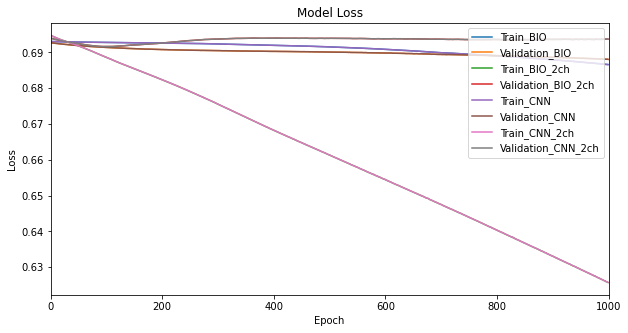

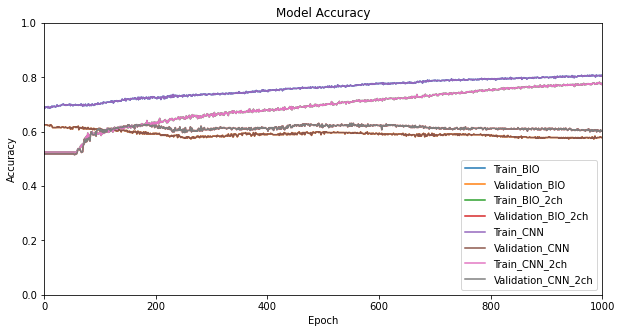

In [651]:
cnn_bio_history_plot = bio_cnn_model_history.history
cnn_bio_history_2ch_plot = bio_cnn_model_2ch_history.history
cnn_history_plot = cnn_model_history.history
cnn_history_2ch_plot = cnn_model_2ch_history.history


plt.figure(figsize=(10, 5))
plt.plot(cnn_bio_history_plot['loss'])
plt.plot(cnn_bio_history_plot['val_loss'])
plt.plot(cnn_bio_history_2ch_plot['loss'])
plt.plot(cnn_bio_history_2ch_plot['val_loss'])

plt.plot(cnn_bio_history_plot['loss'])
plt.plot(cnn_bio_history_plot['val_loss'])
plt.plot(cnn_bio_history_2ch_plot['loss'])
plt.plot(cnn_bio_history_2ch_plot['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, 1000)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BIO_2ch', 'Validation_BIO_2ch', 'Train_CNN', 'Validation_CNN', 
            'Train_CNN_2ch', 'Validation_CNN_2ch'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cnn_history_plot['acc'])
plt.plot(cnn_history_plot['val_acc'])
plt.plot(cnn_history_2ch_plot['acc'])
plt.plot(cnn_history_2ch_plot['val_acc'])

plt.plot(cnn_history_plot['acc'])
plt.plot(cnn_history_plot['val_acc'])
plt.plot(cnn_history_2ch_plot['acc'])
plt.plot(cnn_history_2ch_plot['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.xlim(0, 1000)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BIO_2ch', 'Validation_BIO_2ch', 'Train_CNN', 'Validation_CNN', 
            'Train_CNN_2ch', 'Validation_CNN_2ch'], loc='lower right')
plt.show()